In [771]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

In [772]:
if 'df_original' not in globals():
    df_original = pd.read_csv('https://drive.google.com/uc?id=1w8DnxXGwaF1dLKlMxmXWVQFOH4vcvfTp')

df = df_original.copy()
df.head()

,id,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,1,NaN,https://www.northcm.ac.th,24.0,www.northcm.ac.th,17.0,0.0,NaN,0.800000,NaN,...,0.0,0.0,1.0,NaN,3.0,NaN,69.0,NaN,NaN,1
1,4,8135291.txt,http://uqr.to/1il1z,NaN,NaN,NaN,NaN,to,1.000000,0.000896,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0
2,5,586561.txt,https://www.woolworthsrewards.com.au,35.0,www.woolworthsrewards.com.au,28.0,0.0,au,0.857143,NaN,...,1.0,0.0,1.0,33.0,7.0,8.0,15.0,NaN,2.0,1
3,6,NaN,NaN,31.0,NaN,NaN,NaN,com,0.562500,0.522907,...,1.0,0.0,1.0,24.0,5.0,14.0,NaN,NaN,NaN,1
4,11,412632.txt,NaN,NaN,www.nyprowrestling.com,22.0,0.0,NaN,1.000000,NaN,...,0.0,0.0,1.0,NaN,NaN,14.0,NaN,0.0,NaN,1


In [773]:
#Drop kolom yang tidak digunakan
df = df.drop(columns=['FILENAME'])

In [774]:
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print(f"Ukuran training set: {len(train_set)}")
print(f"Ukuran validation set: {len(val_set)}")

Ukuran training set: 112323
Ukuran validation set: 28081


In [775]:
# Memeriksa duplikasi pada train_set
train_duplicates = train_set.duplicated().sum()
print(f"Jumlah duplikasi pada train_set: {train_duplicates}")

# Memeriksa duplikasi pada val_set
val_duplicates = val_set.duplicated().sum()
print(f"Jumlah duplikasi pada val_set: {val_duplicates}")

Jumlah duplikasi pada train_set: 0
Jumlah duplikasi pada val_set: 0


In [776]:
missing_count = train_set.isnull().sum()

missing_percentage = (missing_count / len(train_set)) * 100

missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Percentage': missing_percentage
})

missing_data_sorted = missing_data.sort_values(by='Missing Count', ascending=False)

print(missing_data_sorted[missing_data_sorted['Missing Count'] > 0])


                            Missing Count  Percentage
Domain                              56165   50.003116
NoOfExternalRef                     55498   49.409293
LineOfCode                          55243   49.182269
HasSocialNet                        54473   48.496746
LargestLineLength                   54339   48.377447
NoOfURLRedirect                     53986   48.063175
HasCopyrightInfo                    53909   47.994623
NoOfSelfRedirect                    53549   47.674118
NoOfCSS                             53549   47.674118
NoOfObfuscatedChar                  53460   47.594883
HasPasswordField                    53344   47.491609
LetterRatioInURL                    52644   46.868406
HasObfuscation                      52518   46.756230
ObfuscationRatio                    51714   46.040437
NoOfLettersInURL                    50650   45.093169
SpacialCharRatioInURL               50197   44.689868
NoOfEqualsInURL                     49236   43.834299
HasSubmitButton             

In [777]:
high_missing_features = missing_count[missing_percentage > 50].index.tolist()
print("Kolom dengan missing > 50%:", high_missing_features)

train_set = train_set.drop(columns=high_missing_features)
val_set = val_set.drop(columns=high_missing_features)

Kolom dengan missing > 50%: ['Domain']


In [778]:
# Identifikasi kolom numerik
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns

# Identifikasi kolom biner
binary_columns = [col for col in numerical_columns if set(train_set[col].dropna().unique()) <= {0, 1}]
print("Kolom biner:", binary_columns)

# Identifikasi kolom non-biner
non_binary_columns = [col for col in numerical_columns if col not in binary_columns]

Kolom biner: ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'label']


In [779]:
# Hitung skewness untuk kolom numerik
skewness = train_set[numerical_columns].skew()
print(skewness)

id                              0.001849
URLLength                     112.096939
DomainLength                    2.058316
IsDomainIP                     47.371785
CharContinuationRate           -1.890852
TLDLegitimateProb              -0.039487
URLCharProb                    -1.168337
TLDLength                       0.972741
NoOfSubDomain                   2.257952
HasObfuscation                 47.033089
NoOfObfuscatedChar            238.493514
ObfuscationRatio               78.351228
NoOfLettersInURL              103.770044
LetterRatioInURL               -0.180367
NoOfDegitsInURL                48.362456
DegitRatioInURL                 7.125303
NoOfEqualsInURL                56.204050
NoOfQMarkInURL                 20.846675
NoOfAmpersandInURL            153.268629
NoOfOtherSpecialCharsInURL    139.175948
SpacialCharRatioInURL           1.770216
IsHTTPS                        -4.822680
LineOfCode                     39.220611
LargestLineLength             116.101916
HasTitle        

In [780]:
# Klasifikasikan kolom berdasarkan skewness
mean_imputation_columns = skewness[skewness.abs() < 0.5].index.tolist()
median_imputation_columns = skewness[skewness.abs() >= 0.5].index.tolist()

print("Kolom dengan imputasi mean:", mean_imputation_columns)
print("Kolom dengan imputasi median:", median_imputation_columns)

Kolom dengan imputasi mean: ['id', 'TLDLegitimateProb', 'LetterRatioInURL', 'HasFavicon', 'Robots', 'HasSubmitButton', 'HasHiddenFields']
Kolom dengan imputasi median: ['URLLength', 'DomainLength', 'IsDomainIP', 'CharContinuationRate', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label']


In [781]:
# Imputasi untuk kolom biner
binary_imputer = SimpleImputer(strategy='most_frequent')
train_set[binary_columns] = binary_imputer.fit_transform(train_set[binary_columns])

# Imputasi mean untuk kolom dengan skewness rendah
mean_imputer = SimpleImputer(strategy='mean')
train_set[mean_imputation_columns] = mean_imputer.fit_transform(train_set[mean_imputation_columns])

# Imputasi median untuk kolom dengan skewness tinggi
median_imputer = SimpleImputer(strategy='median')
train_set[median_imputation_columns] = median_imputer.fit_transform(train_set[median_imputation_columns])

# Terapkan transformasi ke validation set menggunakan parameter dari train set
val_set[binary_columns] = binary_imputer.transform(val_set[binary_columns])
val_set[mean_imputation_columns] = mean_imputer.transform(val_set[mean_imputation_columns])
val_set[median_imputation_columns] = median_imputer.transform(val_set[median_imputation_columns])

In [782]:
# Hitung missing values untuk kolom object
categorical_columns = train_set.select_dtypes(include=['object']).columns
missing_categorical = train_set[categorical_columns].isnull().sum()

# Proporsi missing values per kolom
missing_percentage = (missing_categorical / len(train_set)) * 100
print("Missing values untuk kolom object:\n", missing_percentage)


Missing values untuk kolom object:
 URL      30.868121
TLD      32.305049
Title    41.567622
dtype: float64


In [783]:
# Hapus kolom yang tidak penting
train_set = train_set.drop(columns=['URL', 'Title', 'TLD'])
val_set = val_set.drop(columns=['URL', 'Title', 'TLD'])


In [784]:
# Periksa jumlah nilai unik di setiap kolom
print(train_set.nunique())

# Identifikasi kolom dengan nilai konstan
constant_columns = train_set.nunique()[train_set.nunique() <= 1].index
print("Kolom dengan nilai konstan:", constant_columns)

# Hapus kolom dengan nilai konstan
train_set = train_set.drop(columns=constant_columns)
val_set = val_set.drop(columns=constant_columns)


id                            112323
URLLength                        201
DomainLength                      76
IsDomainIP                         2
CharContinuationRate             426
TLDLegitimateProb                394
URLCharProb                    70098
TLDLength                         10
NoOfSubDomain                      6
HasObfuscation                     2
NoOfObfuscatedChar                 6
ObfuscationRatio                  24
NoOfLettersInURL                 180
LetterRatioInURL                 481
NoOfDegitsInURL                   76
DegitRatioInURL                  358
NoOfEqualsInURL                   13
NoOfQMarkInURL                     4
NoOfAmpersandInURL                14
NoOfOtherSpecialCharsInURL        42
SpacialCharRatioInURL            172
IsHTTPS                            2
LineOfCode                      7665
LargestLineLength              15137
HasTitle                           2
DomainTitleMatchScore            105
URLTitleMatchScore               184
H

In [785]:
missing_train = train_set.isnull().sum()
missing_train_percentage = (missing_train / len(train_set)) * 100

print("Missing values di Train Set setelah imputasi:")
print(pd.DataFrame({
    'Missing Count': missing_train[missing_train > 0],
    'Percentage': missing_train_percentage[missing_train > 0]
}))

missing_val = val_set.isnull().sum()
missing_val_percentage = (missing_val / len(val_set)) * 100

print("\nMissing values di Validation Set setelah imputasi:")
print(pd.DataFrame({
    'Missing Count': missing_val[missing_val > 0],
    'Percentage': missing_val_percentage[missing_val > 0]
}))

Missing values di Train Set setelah imputasi:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

Missing values di Validation Set setelah imputasi:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []


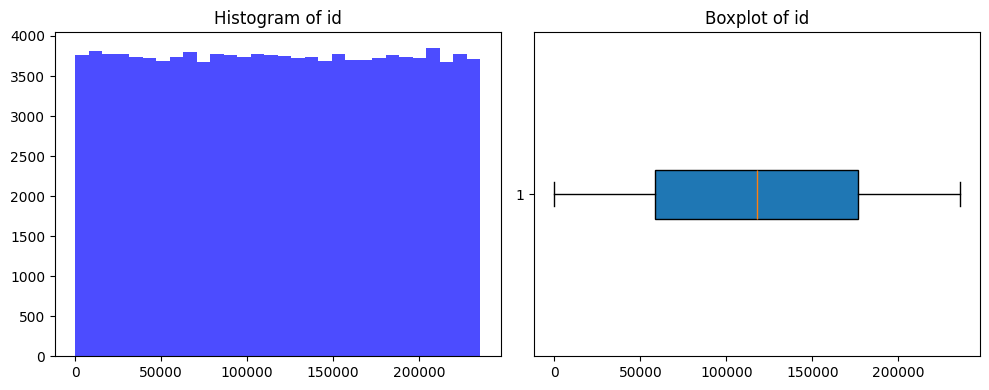

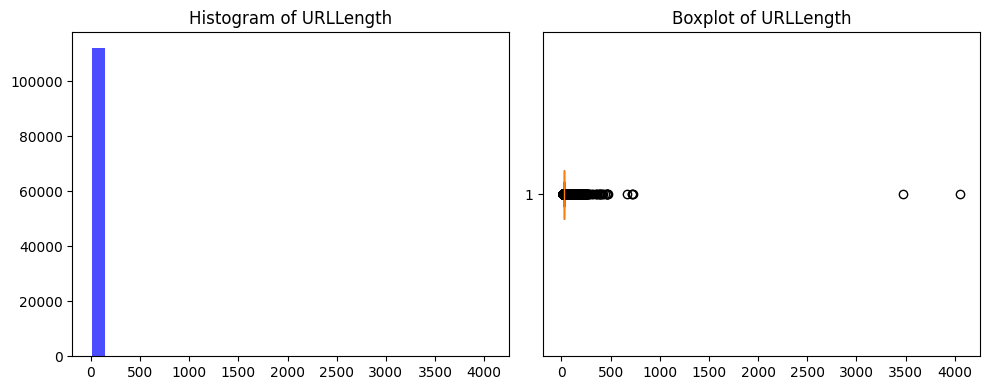

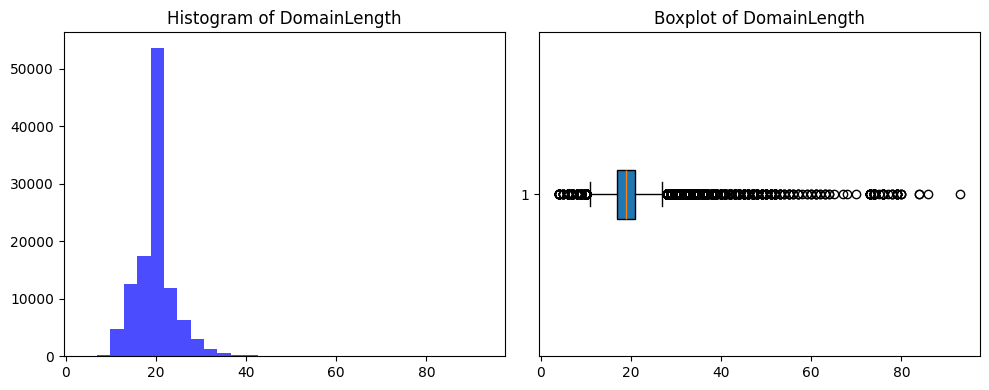

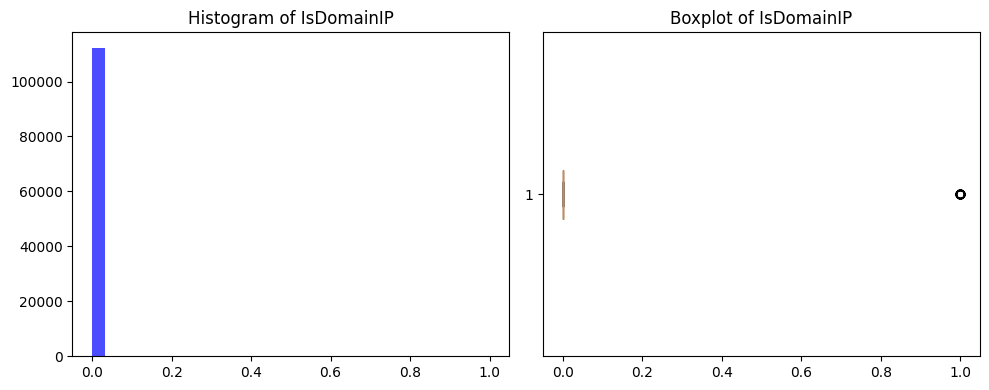

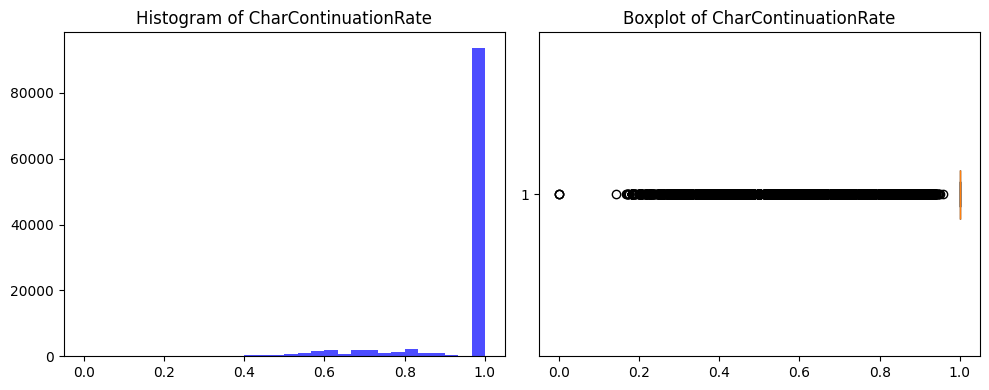

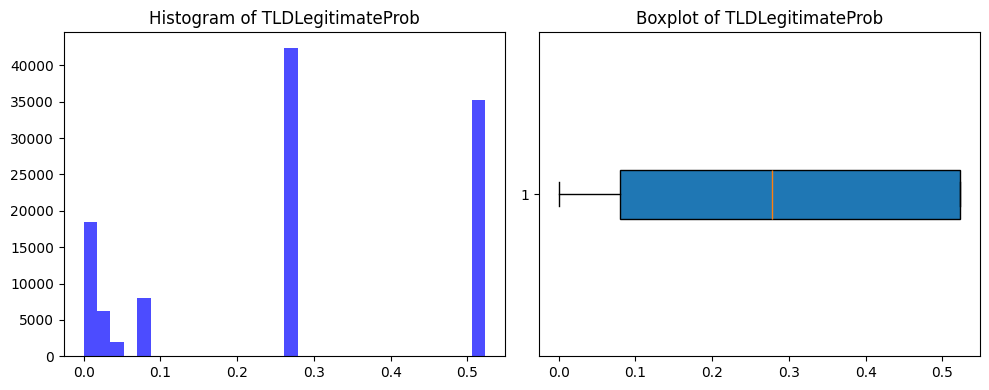

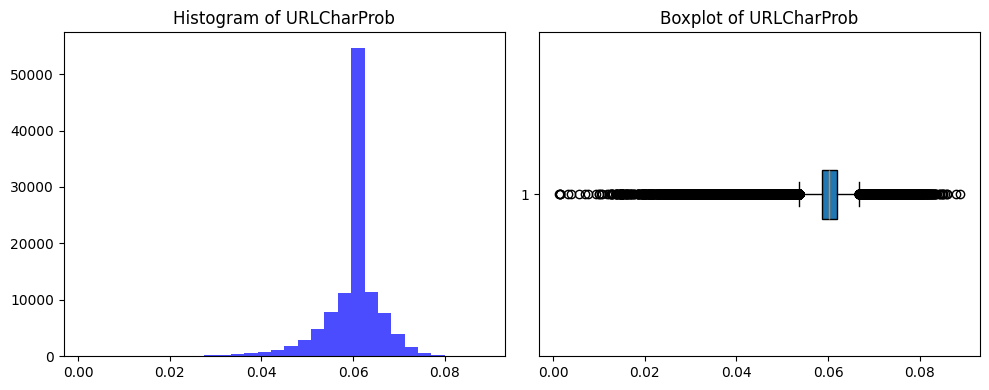

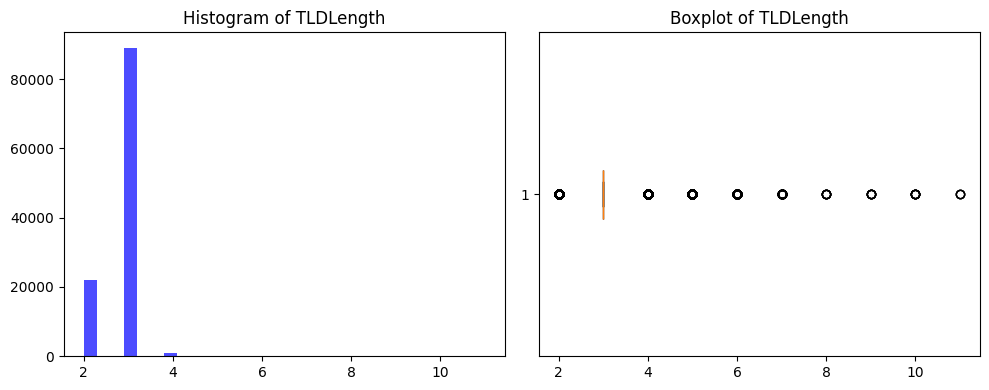

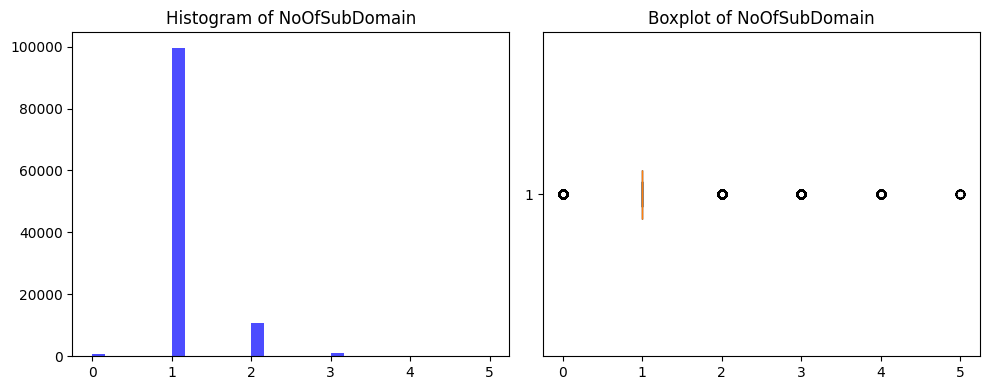

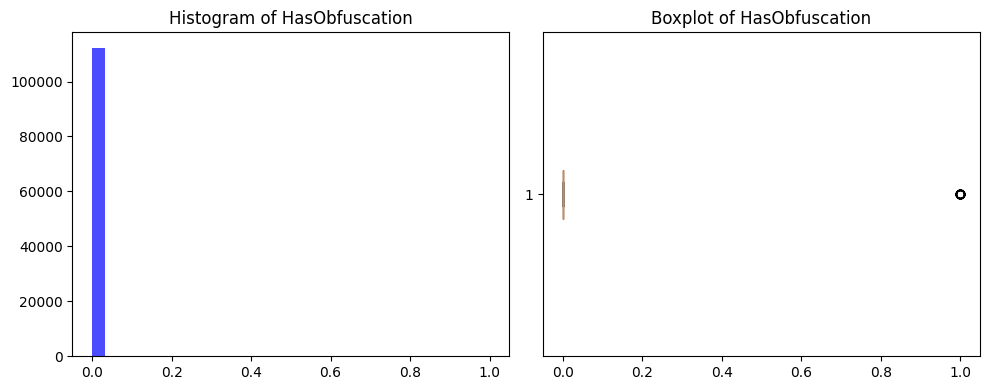

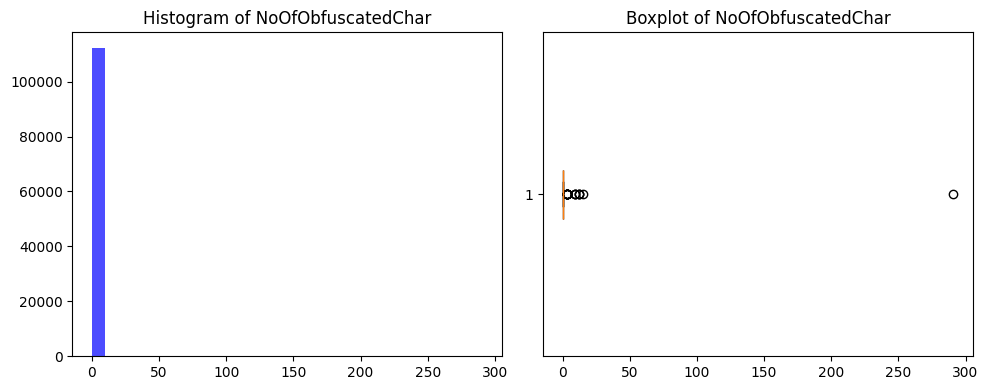

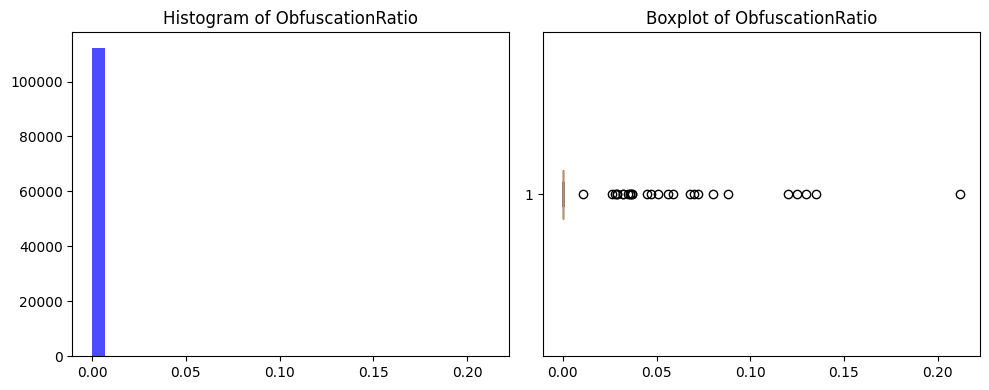

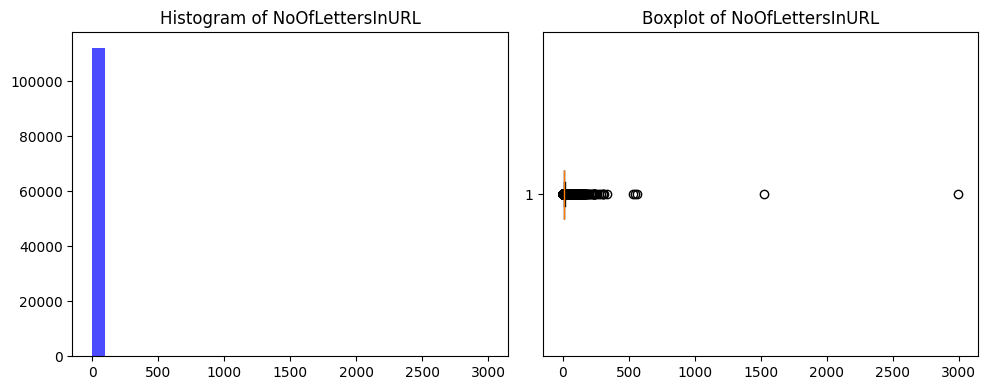

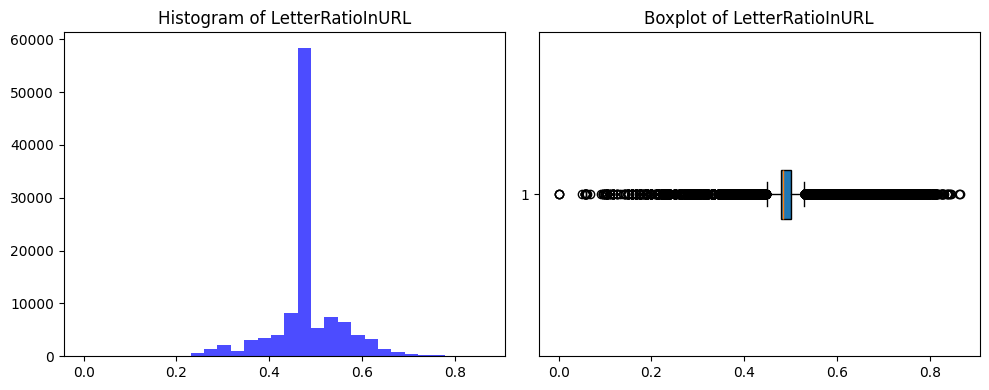

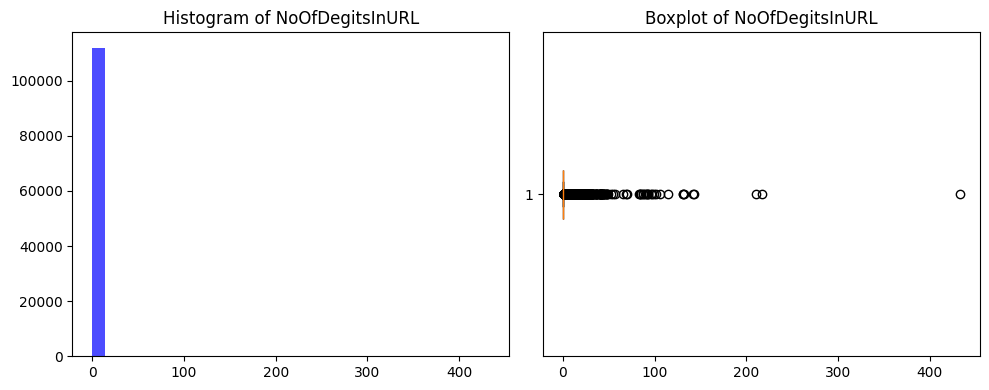

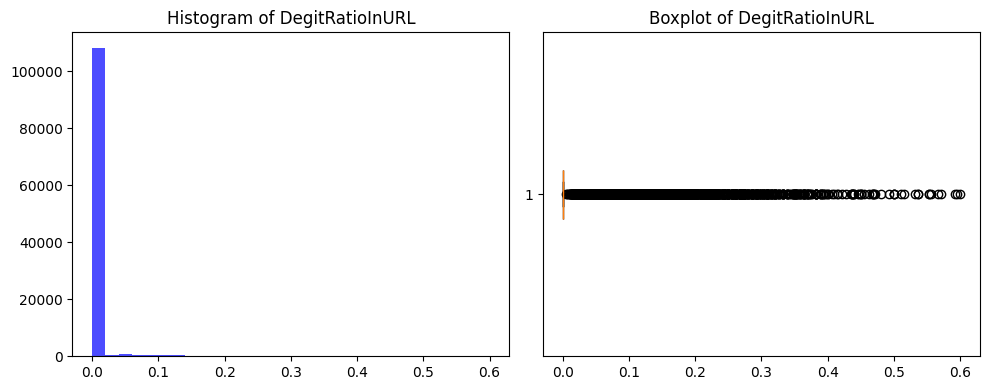

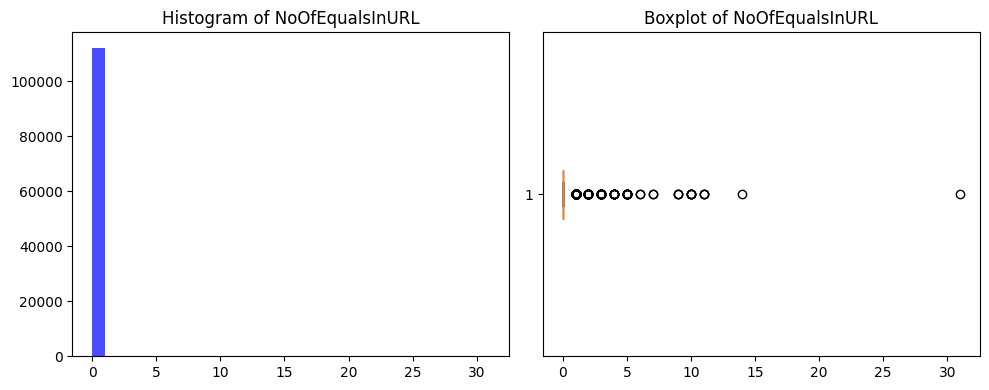

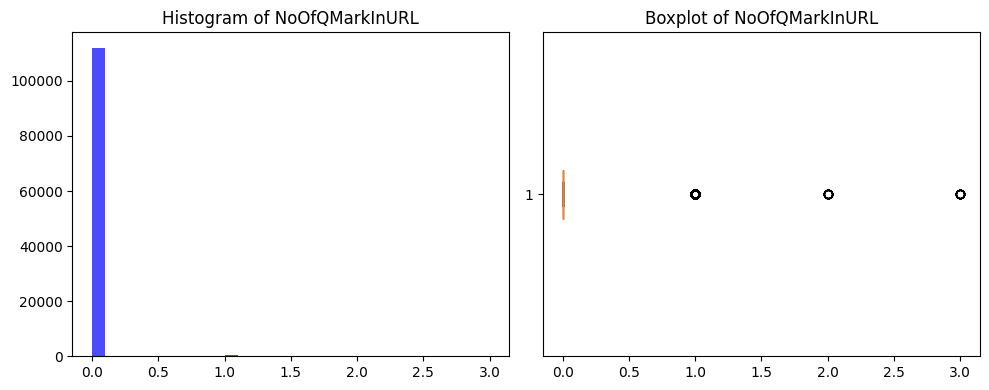

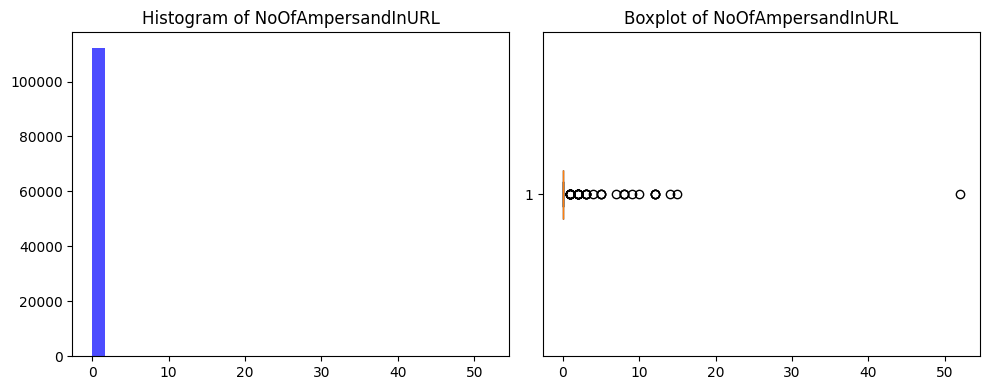

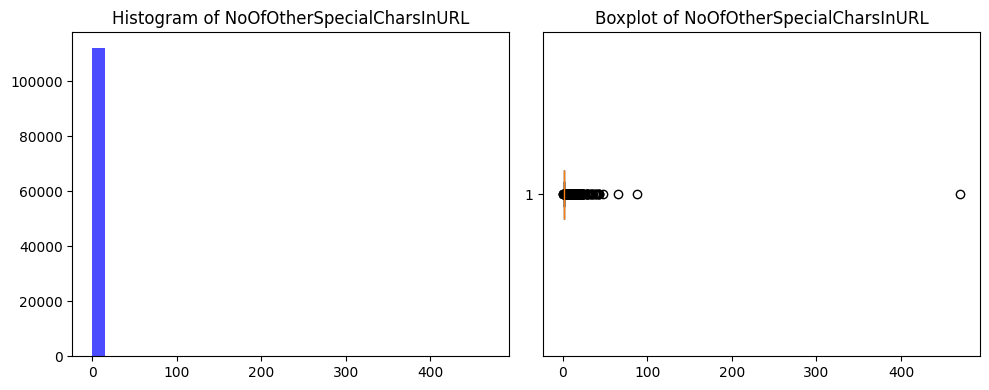

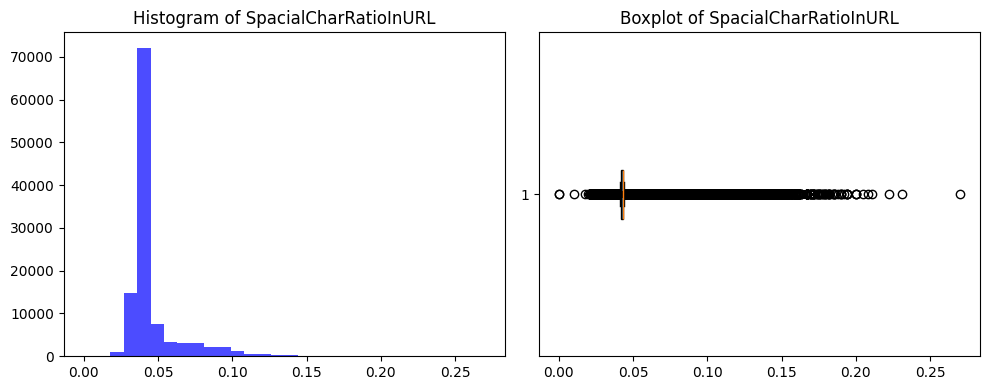

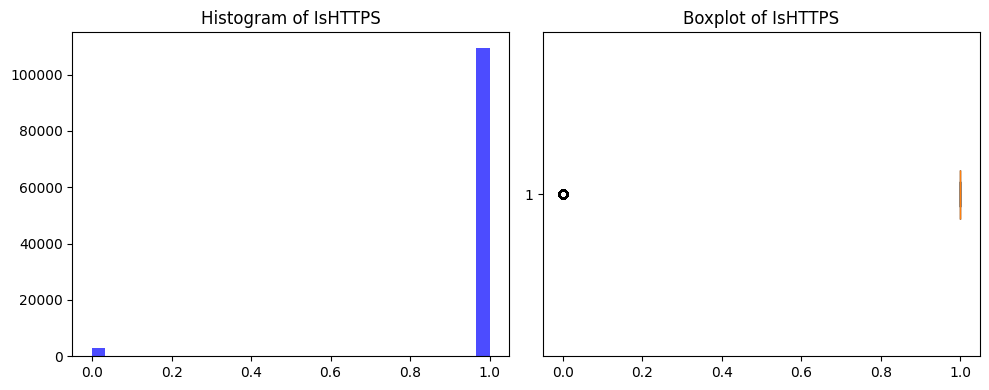

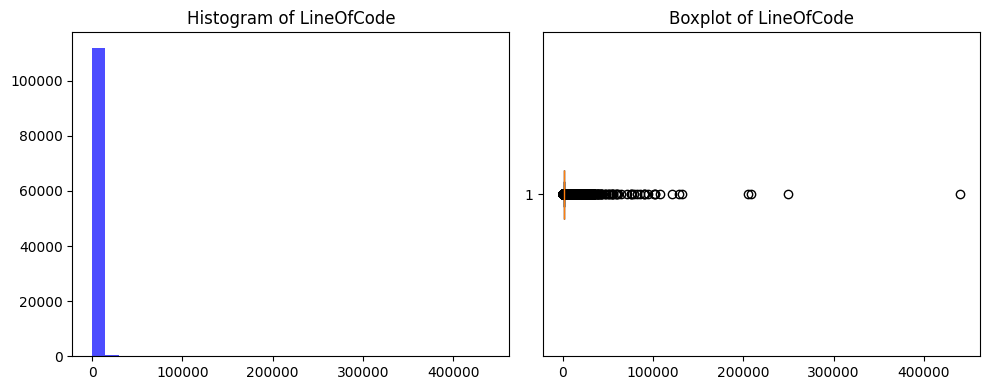

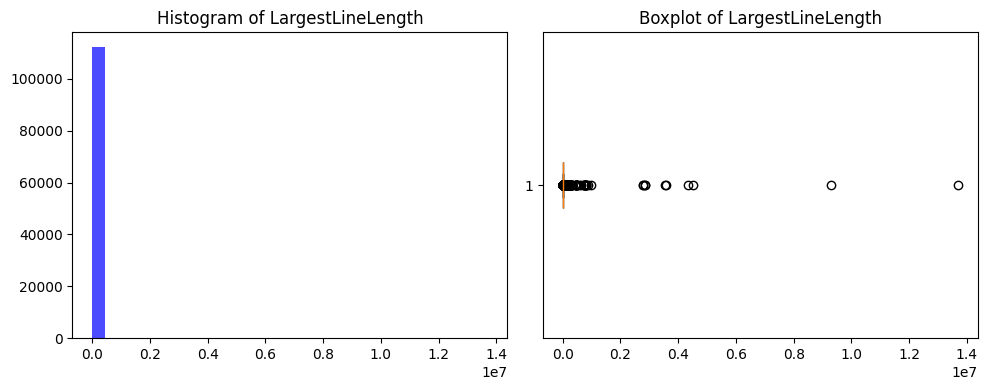

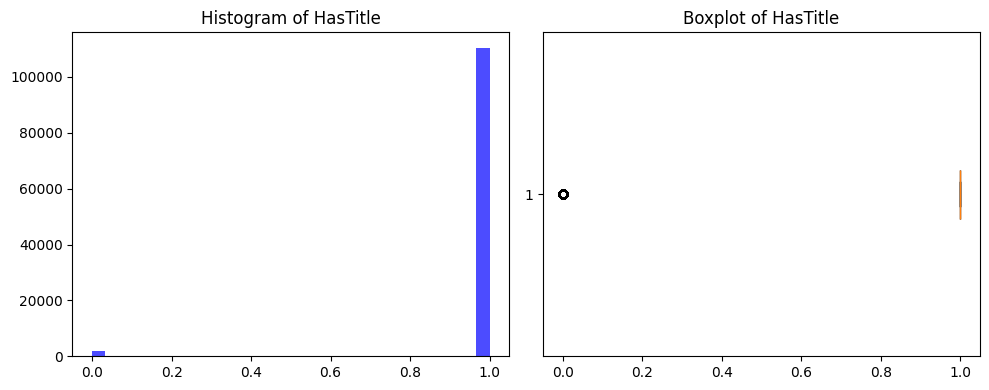

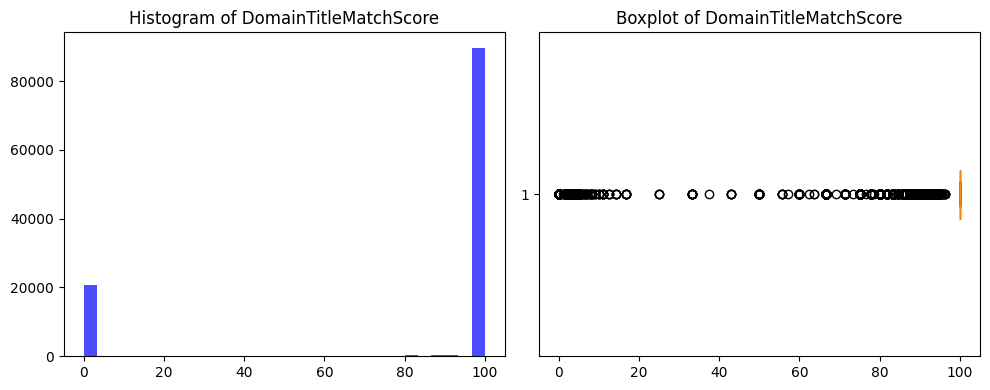

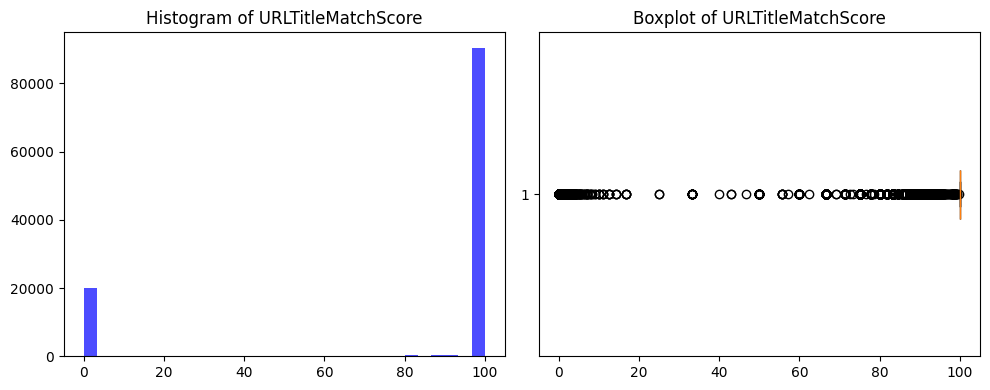

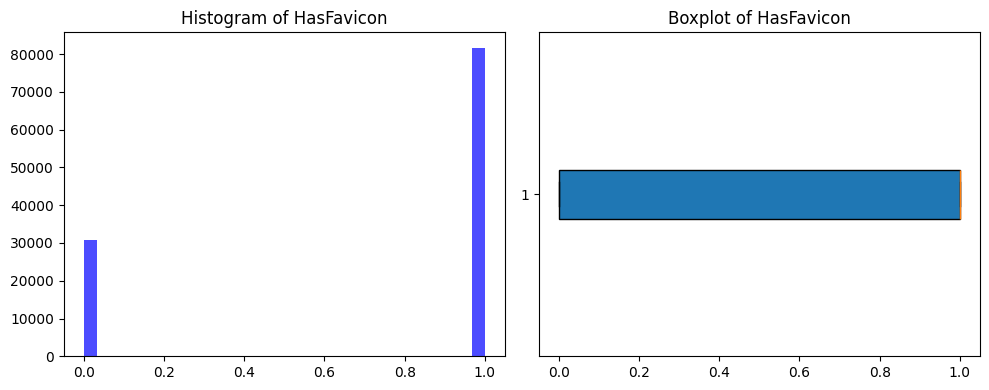

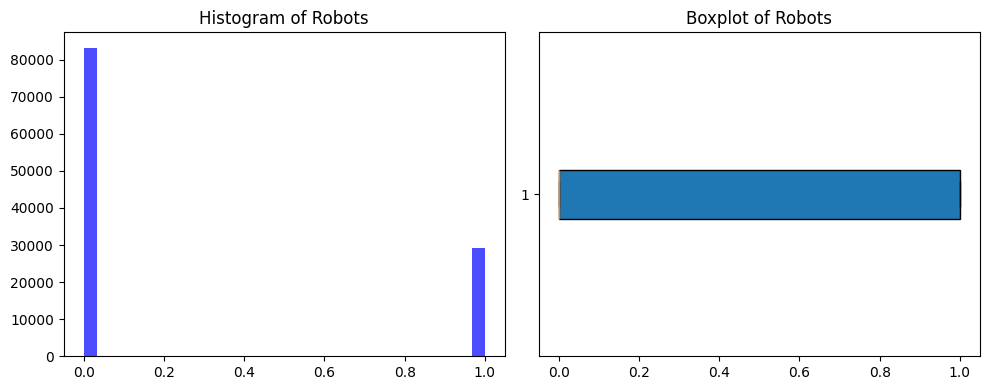

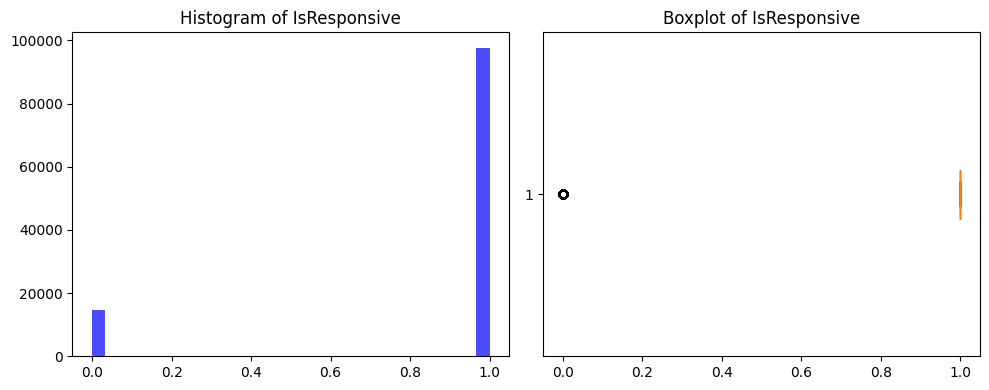

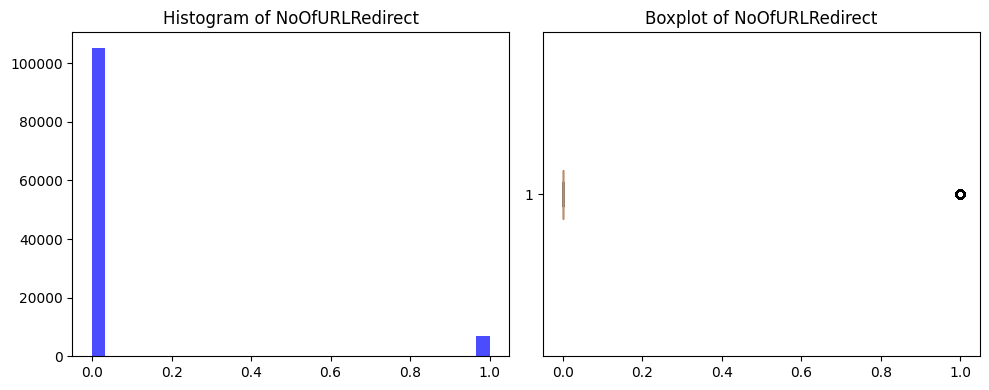

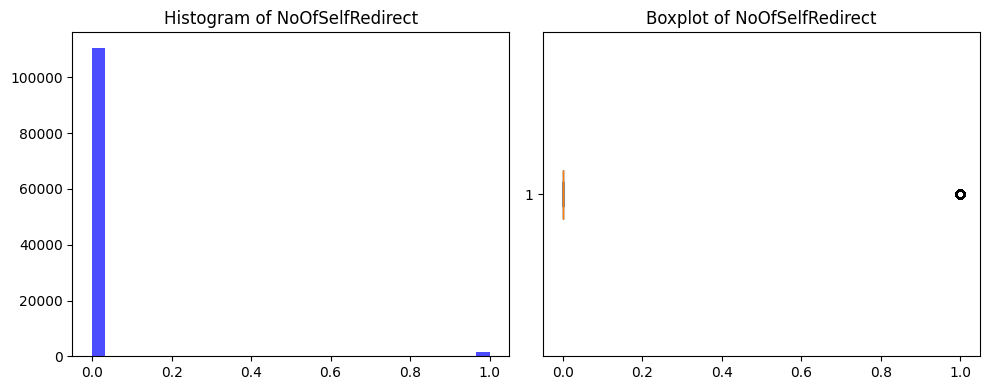

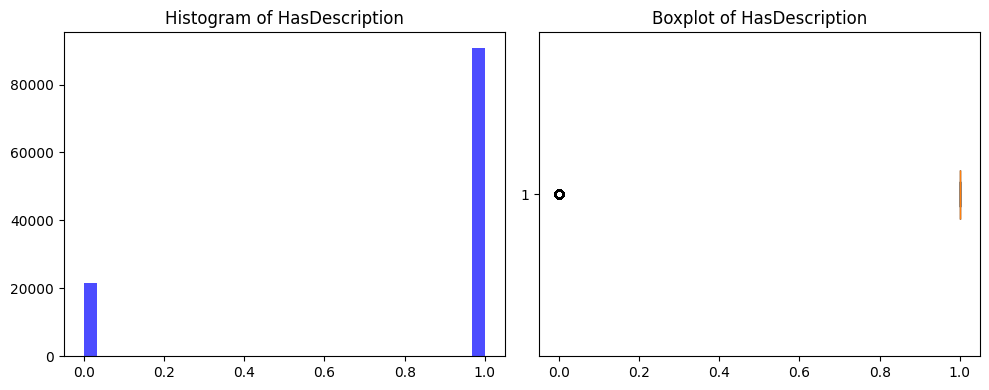

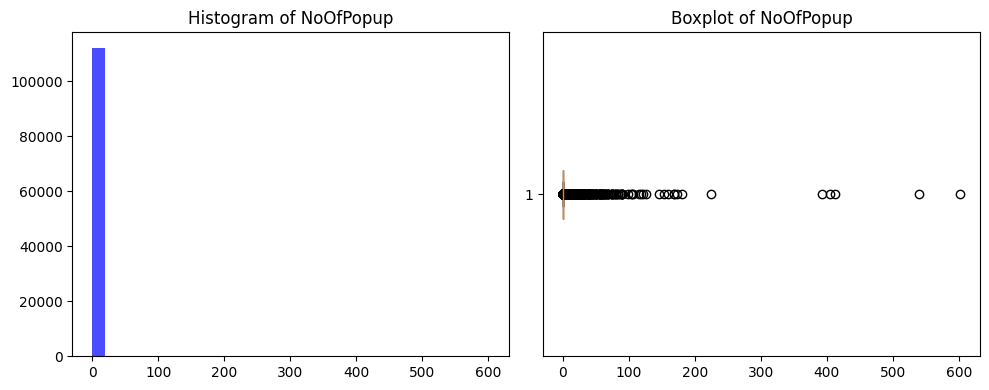

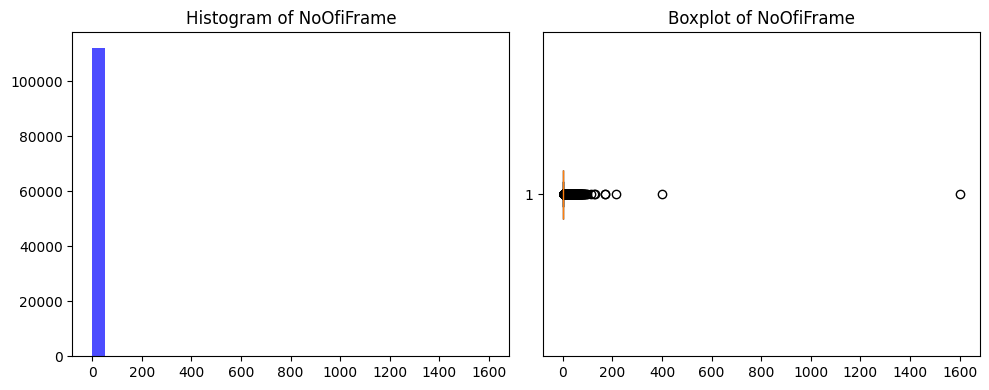

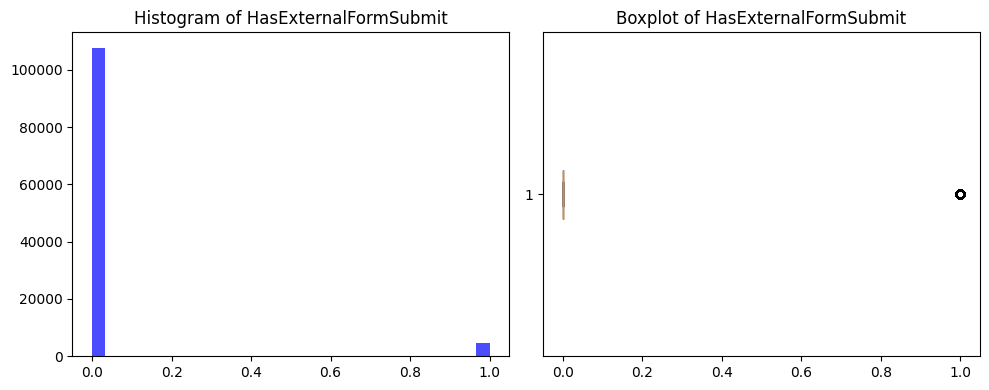

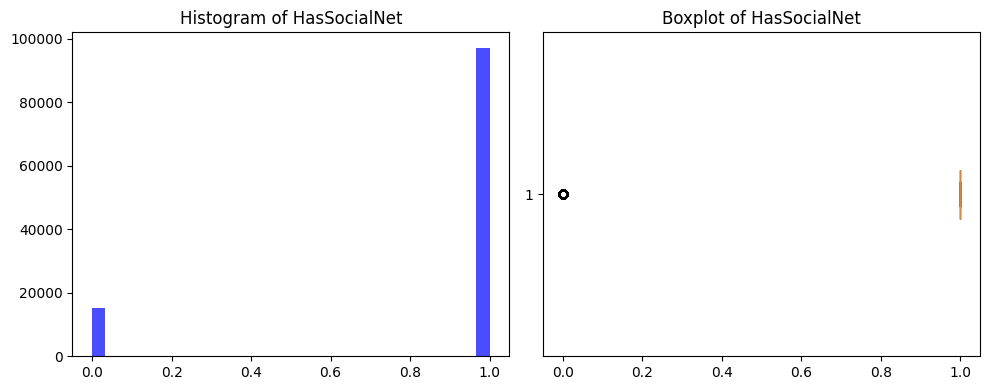

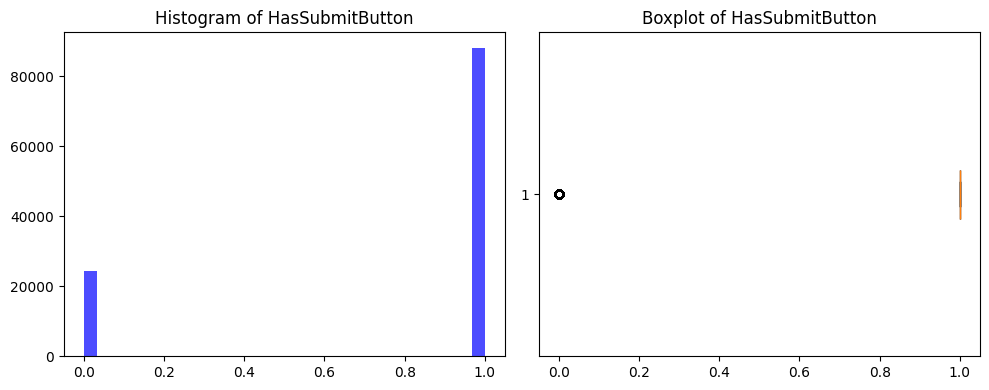

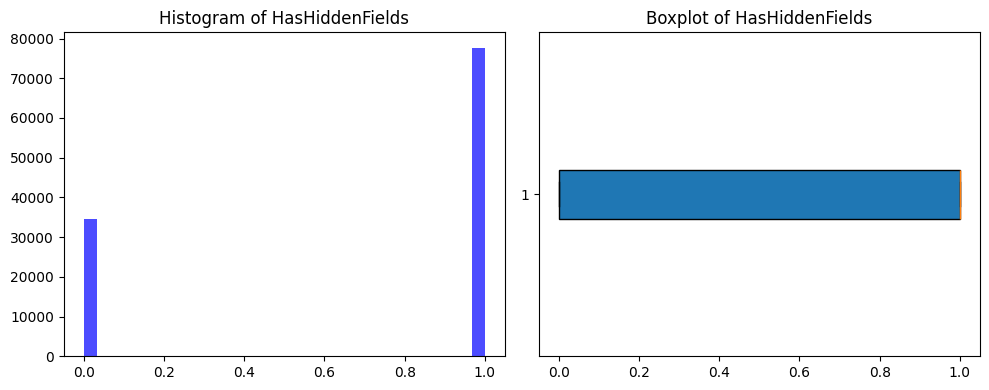

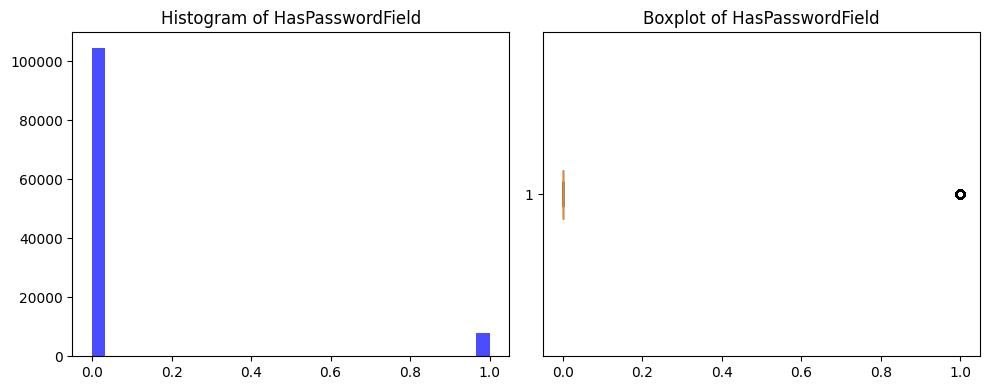

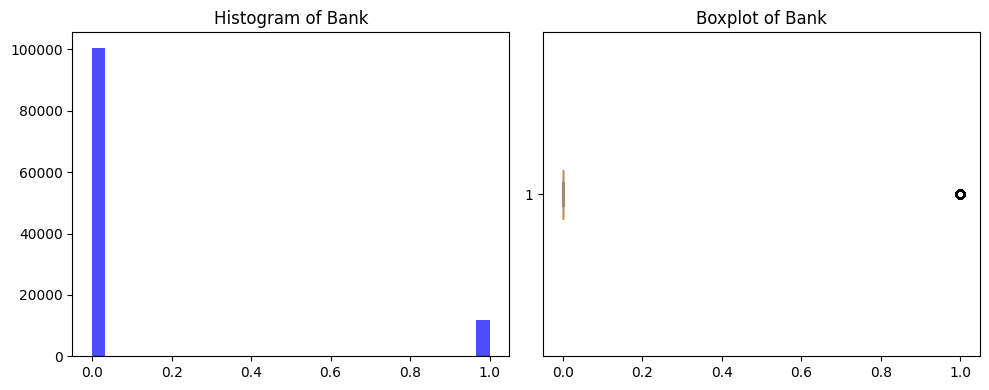

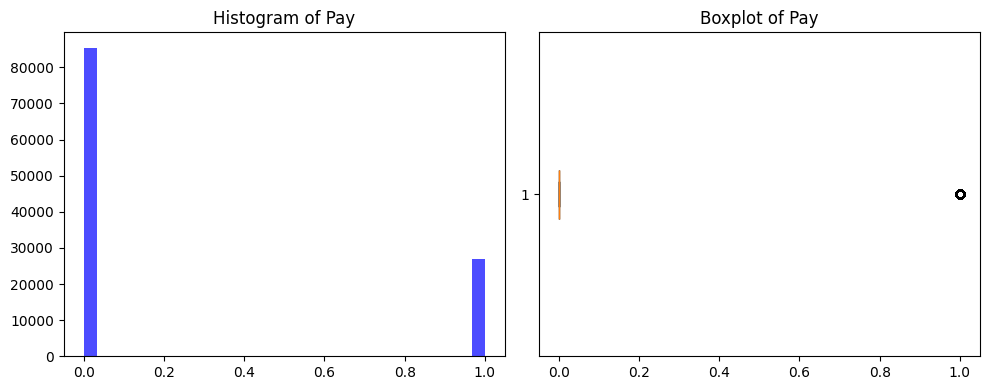

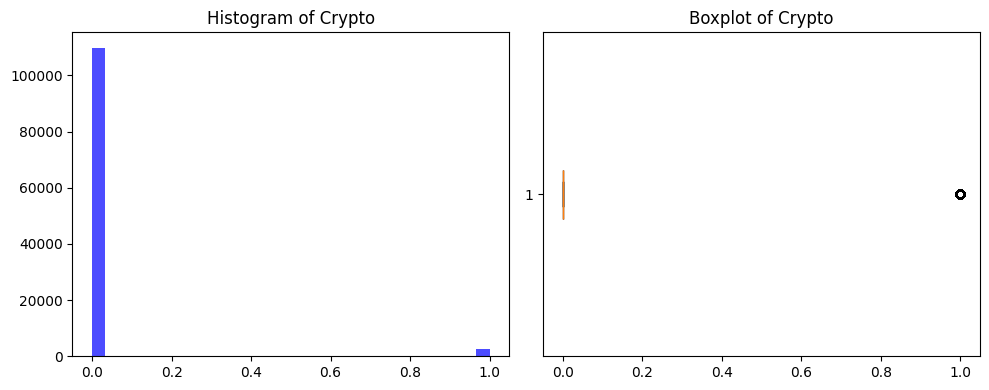

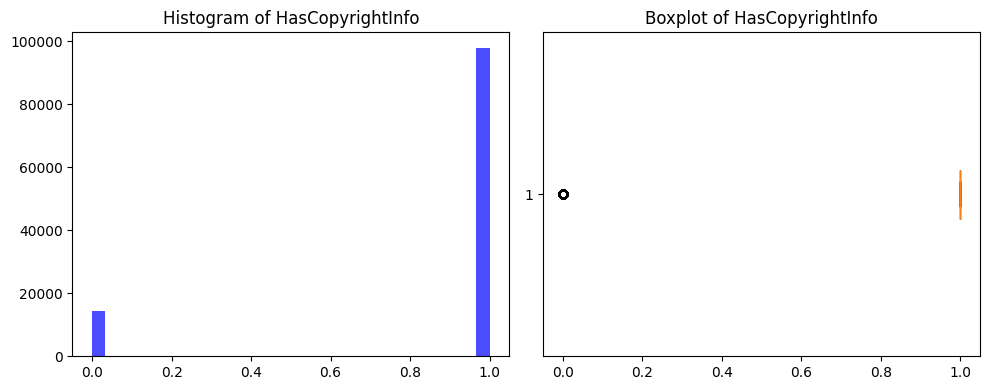

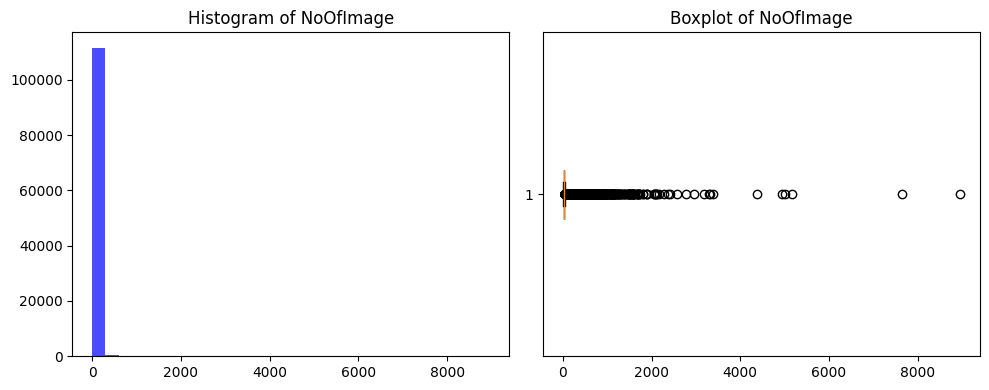

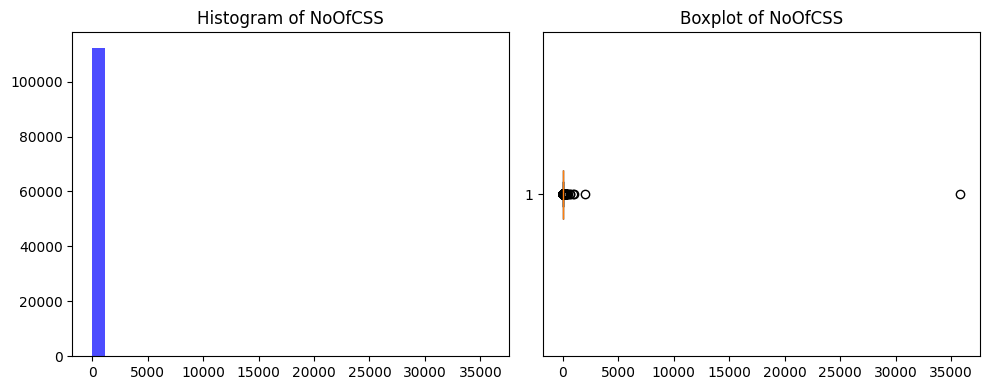

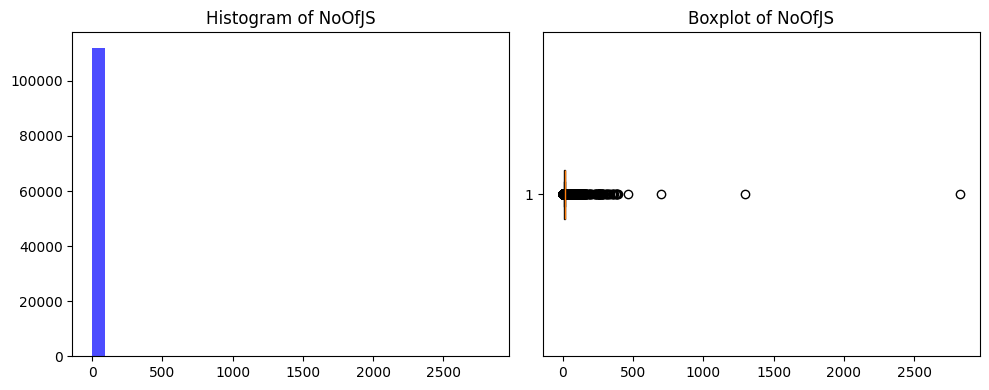

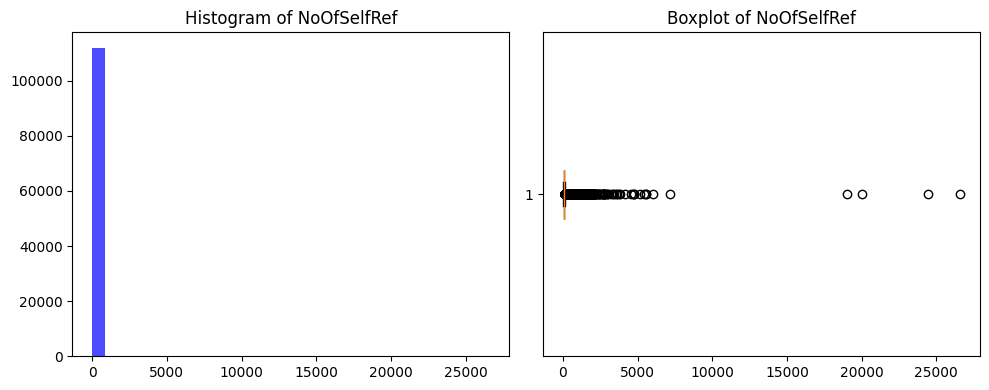

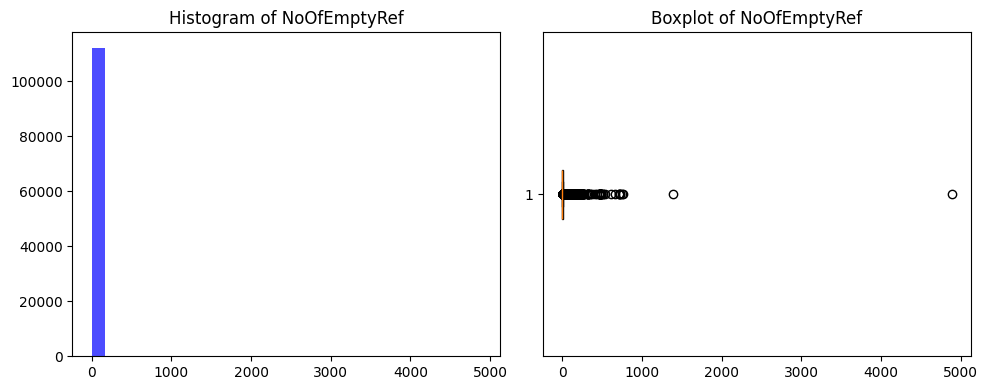

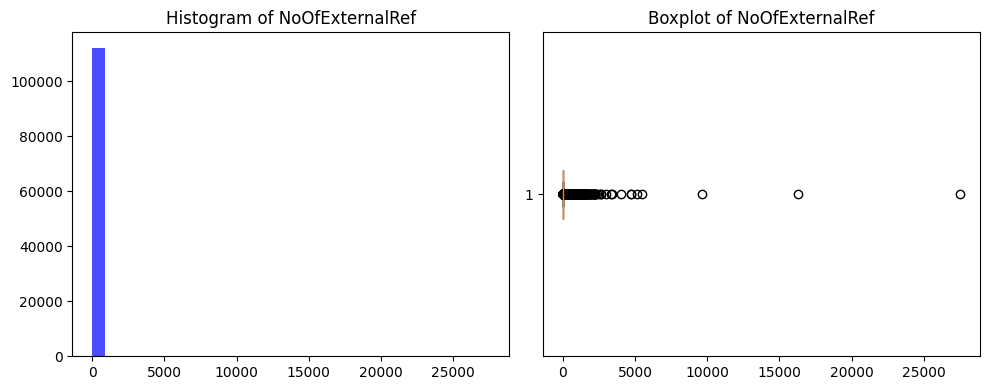

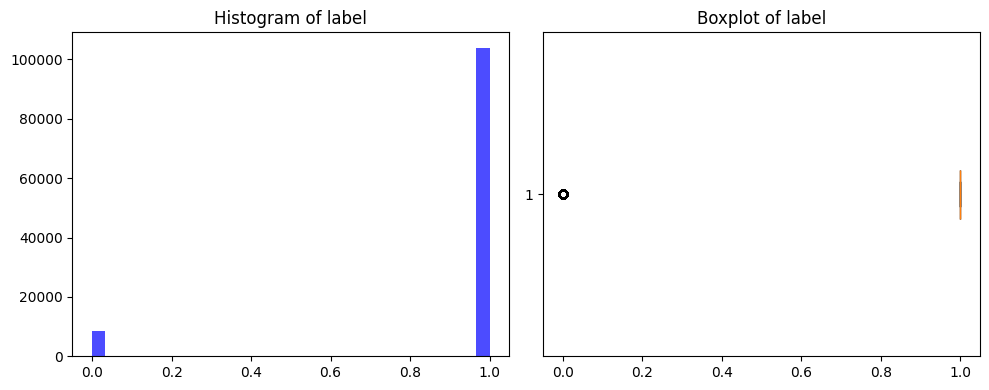

                            IQR Lower Bound  IQR Upper Bound  \
id                           -118309.000000    353919.000000   
URLLength                         22.000000        30.000000   
DomainLength                      11.000000        27.000000   
IsDomainIP                         0.000000         0.000000   
CharContinuationRate               1.000000         1.000000   
TLDLegitimateProb                 -0.584454         1.187324   
URLCharProb                        0.053637         0.066845   
TLDLength                          3.000000         3.000000   
NoOfSubDomain                      1.000000         1.000000   
HasObfuscation                     0.000000         0.000000   
NoOfObfuscatedChar                 0.000000         0.000000   
ObfuscationRatio                   0.000000         0.000000   
NoOfLettersInURL                  10.500000        14.500000   
LetterRatioInURL                   0.450000         0.530000   
NoOfDegitsInURL                    0.000

In [786]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore


numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns


outlier_analysis = {}


for col in numerical_columns:
    
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    z_scores = zscore(train_set[col].dropna())
    z_outliers = np.abs(z_scores) > 3  

    
    outlier_analysis[col] = {
        "IQR Lower Bound": lower_bound,
        "IQR Upper Bound": upper_bound,
        "Z-Score Outliers Count": z_outliers.sum(),
        "IQR Outliers Count": ((train_set[col] < lower_bound) | (train_set[col] > upper_bound)).sum(),
        "Skewness": train_set[col].skew()
    }

    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(train_set[col].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(train_set[col].dropna(), vert=False, patch_artist=True)
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


outlier_df = pd.DataFrame(outlier_analysis).T
print(outlier_df)


# Outliers

In [787]:
# Identifikasi kolom numerik
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns

# Identifikasi kolom biner
binary_columns = [col for col in numerical_columns if set(train_set[col].dropna().unique()) <= {0, 1}]

# Proses train set dengan clipping (skip kolom biner)
parameters = {}

for col in numerical_columns:
    if col in binary_columns:
        continue  # Skip kolom biner

    # Hitung IQR
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Simpan parameter untuk validation set
    parameters[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

    # Clipping untuk train set
    train_set[col] = train_set[col].clip(lower=lower_bound, upper=upper_bound)

# Terapkan parameter ke validation set
for col in numerical_columns:
    if col in binary_columns:
        continue  # Skip kolom biner

    lower_bound = parameters[col]['lower_bound']
    upper_bound = parameters[col]['upper_bound']

    # Clipping untuk validation set
    val_set[col] = val_set[col].clip(lower=lower_bound, upper=upper_bound)


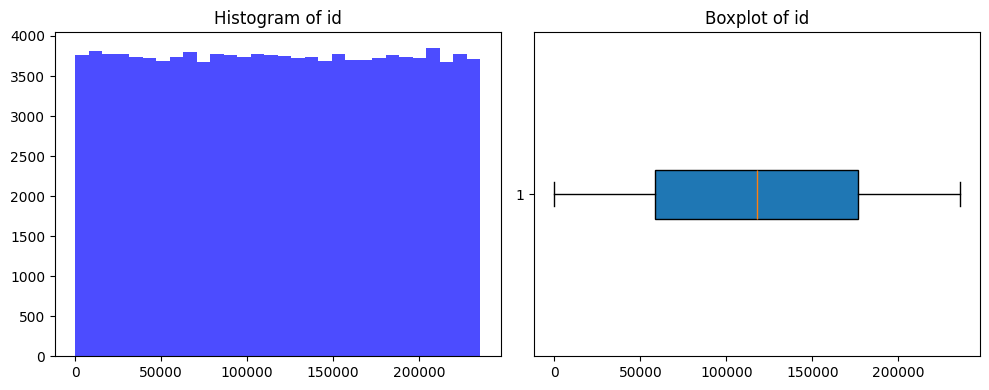

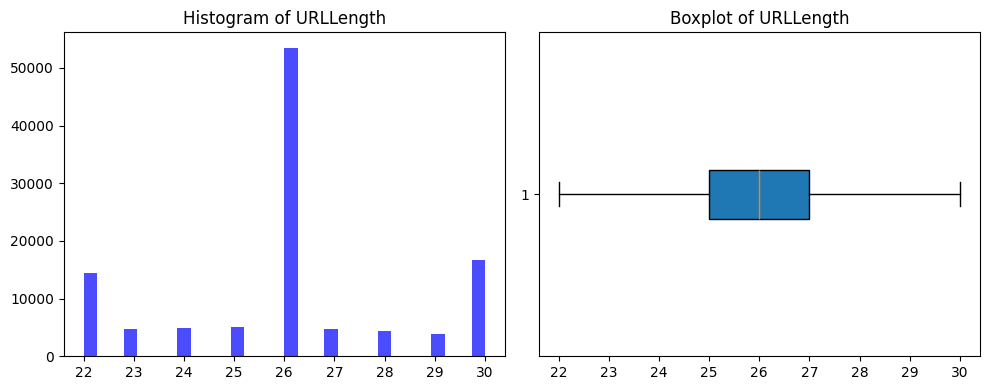

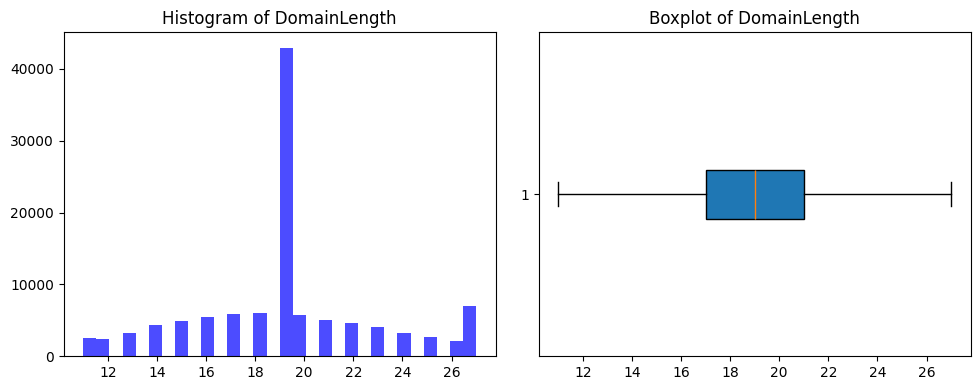

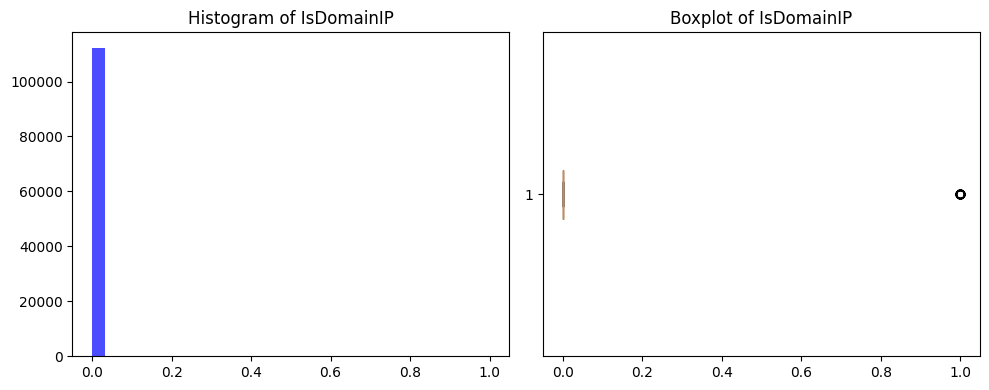

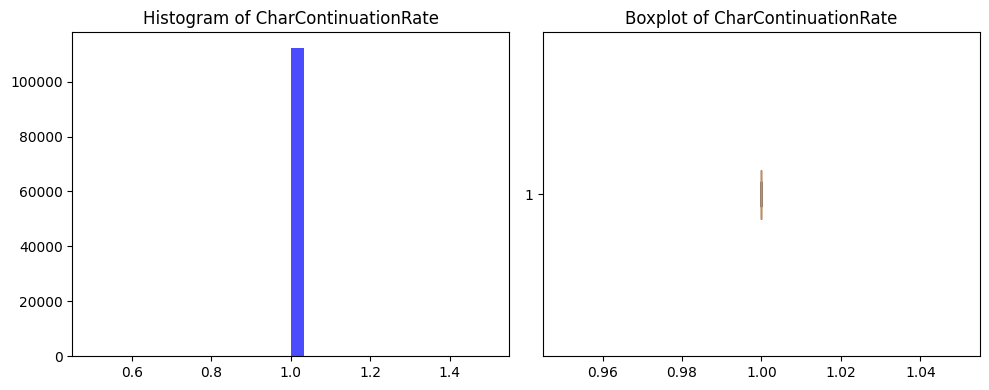

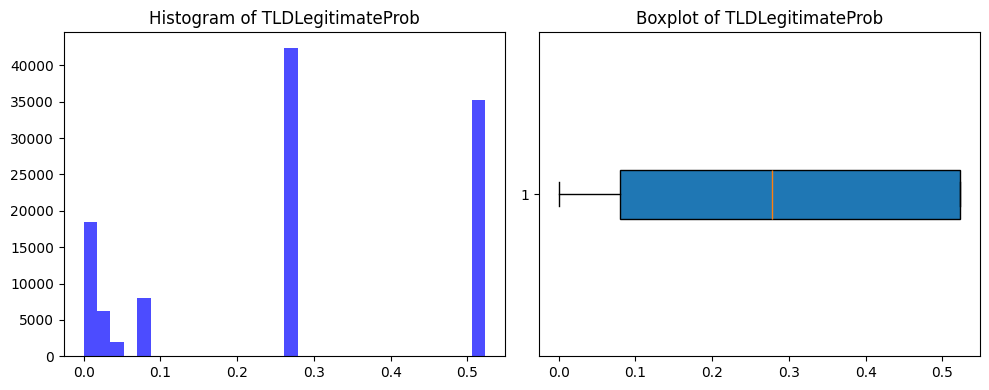

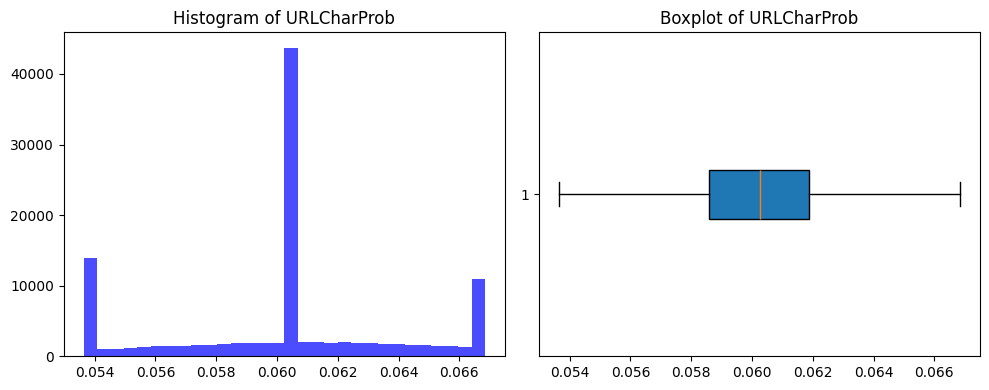

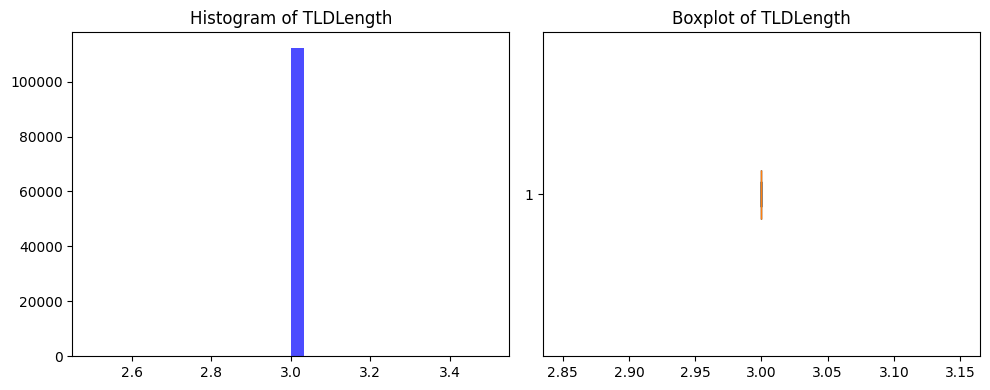

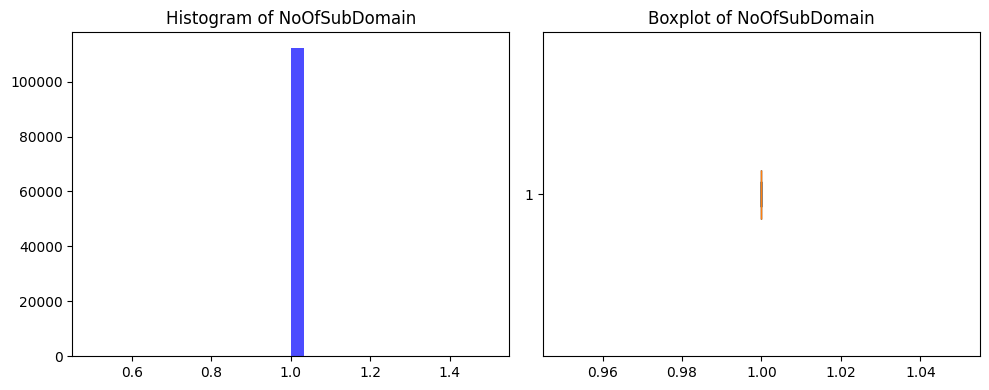

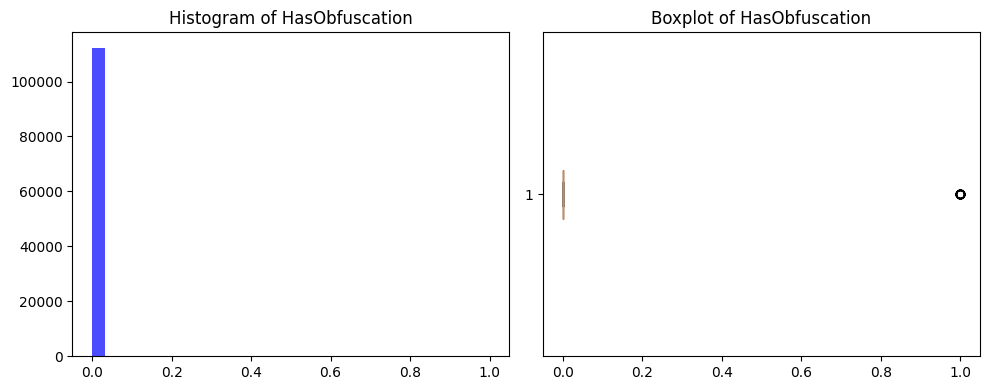

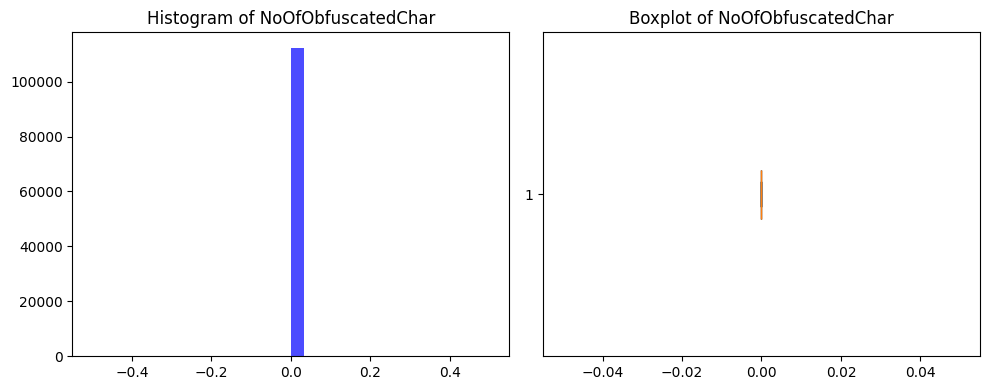

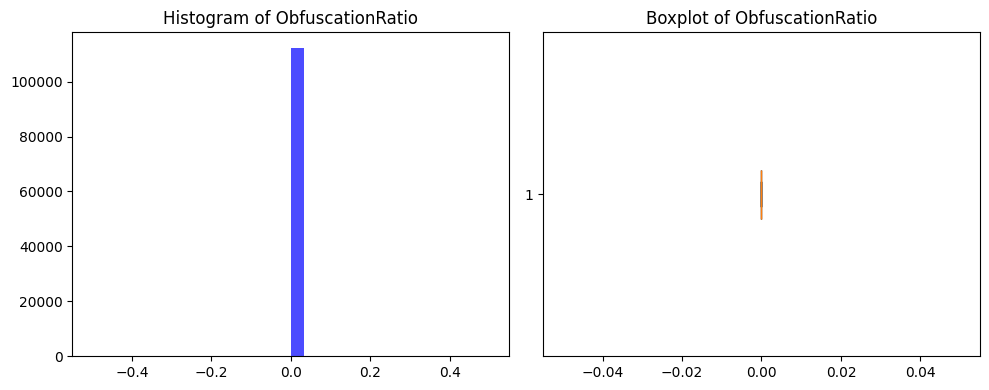

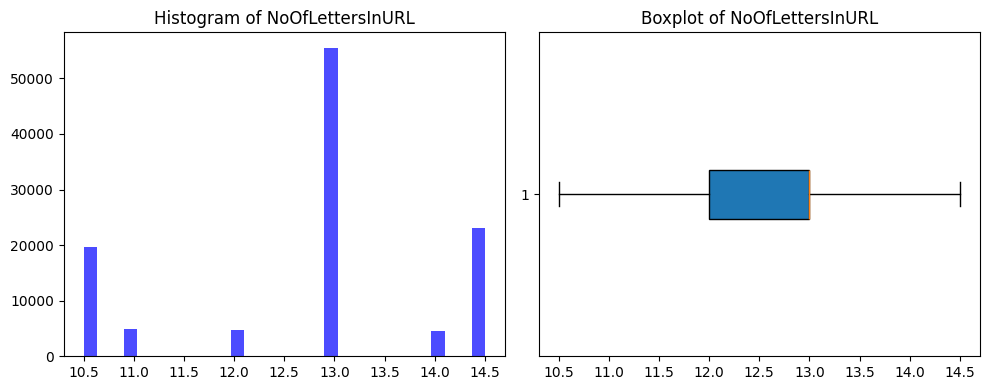

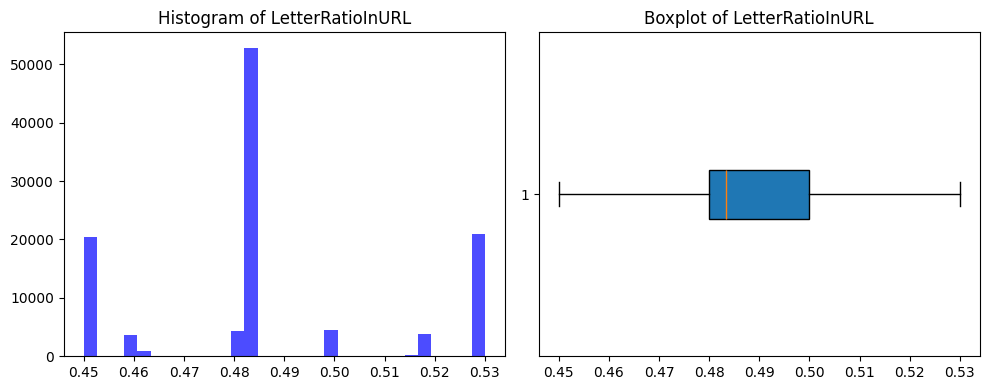

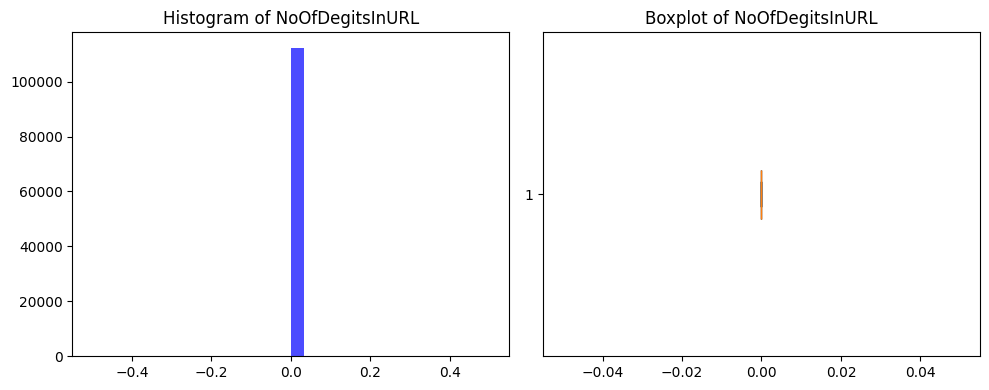

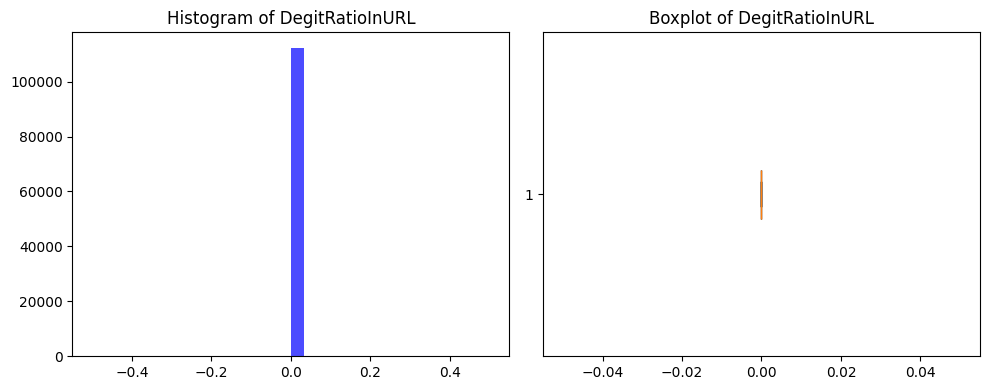

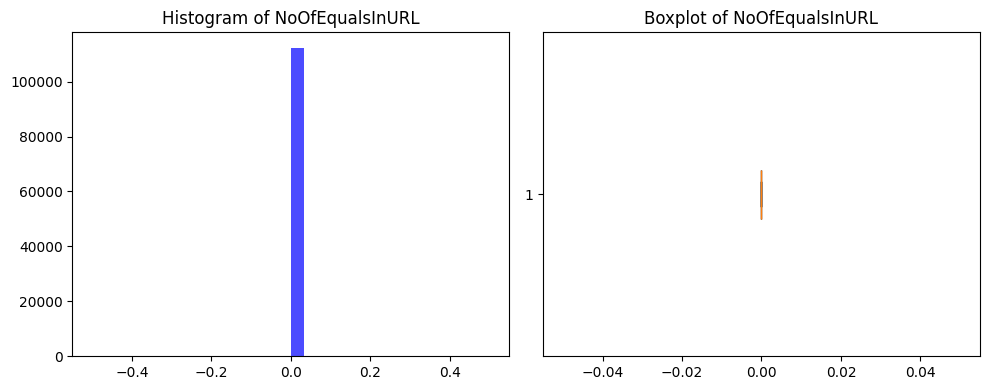

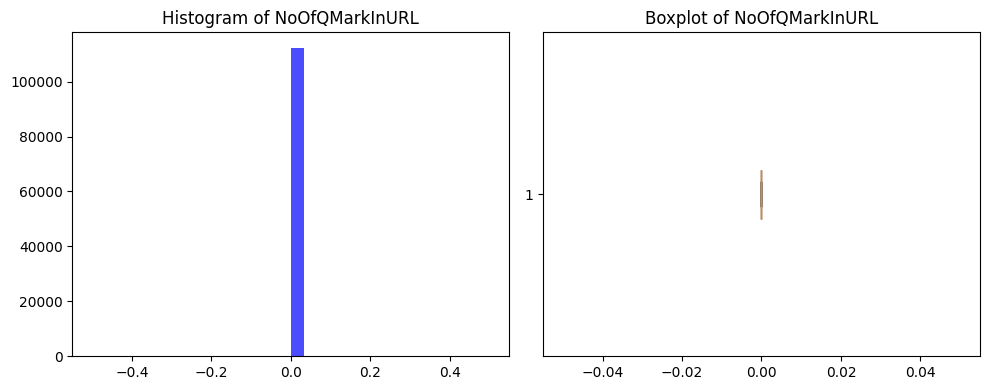

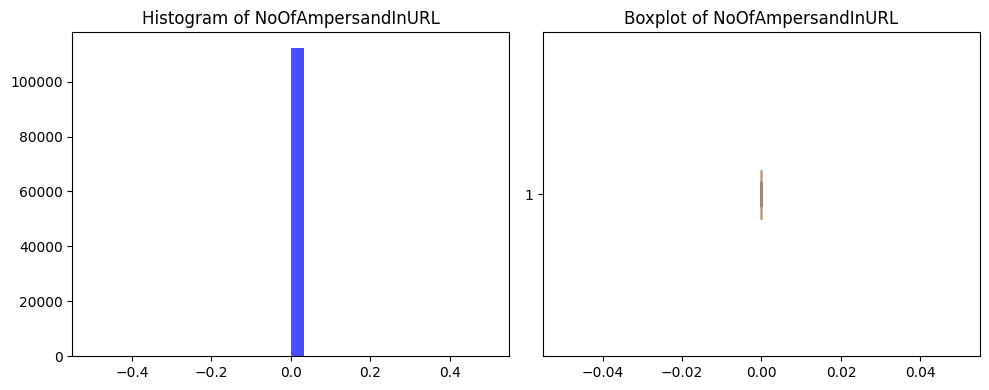

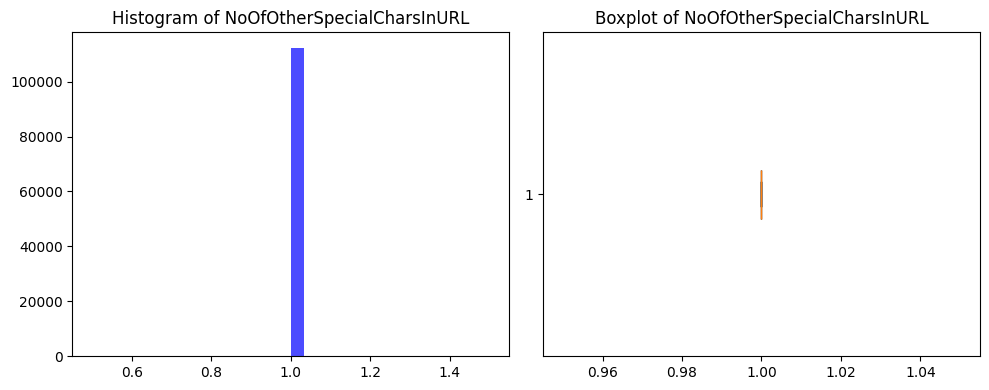

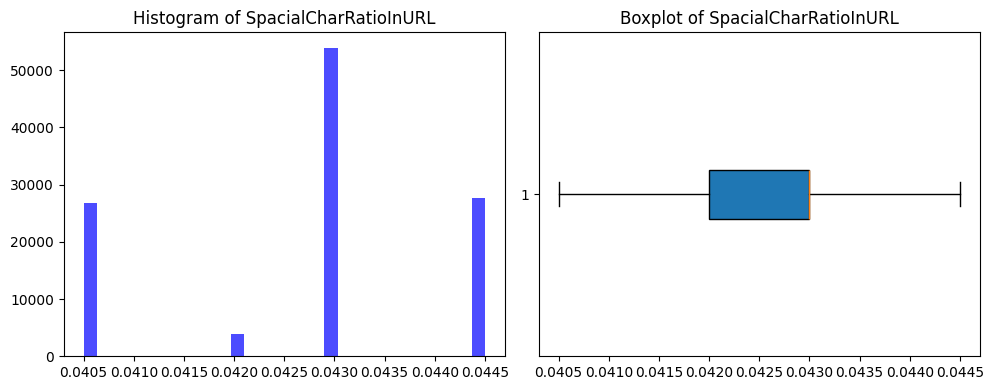

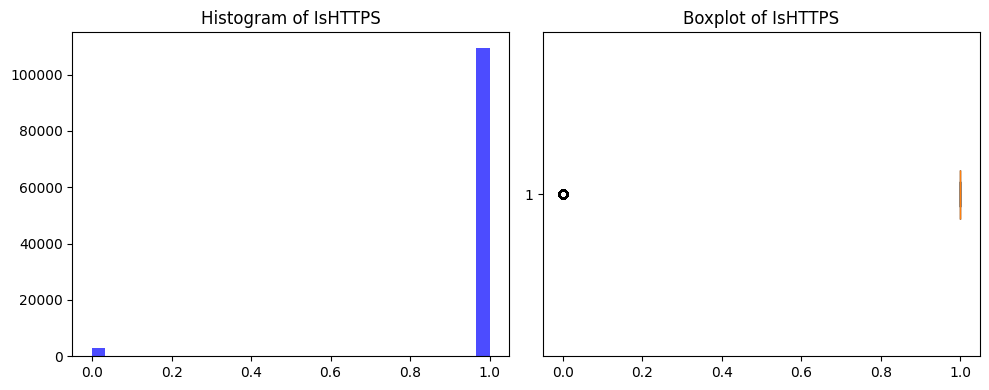

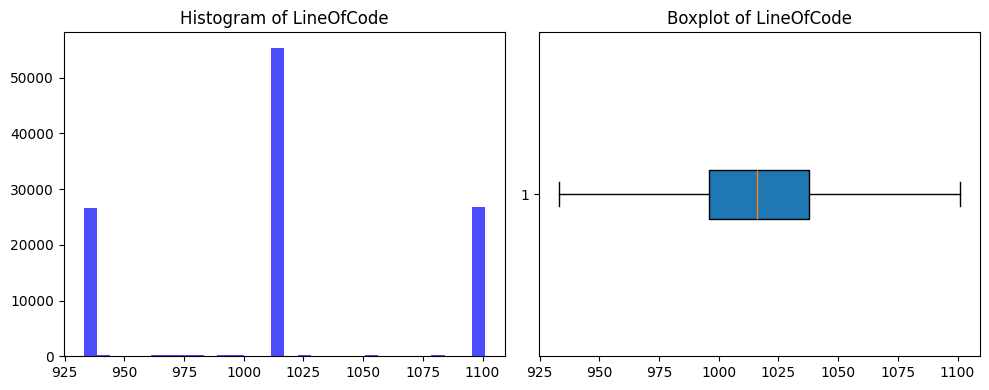

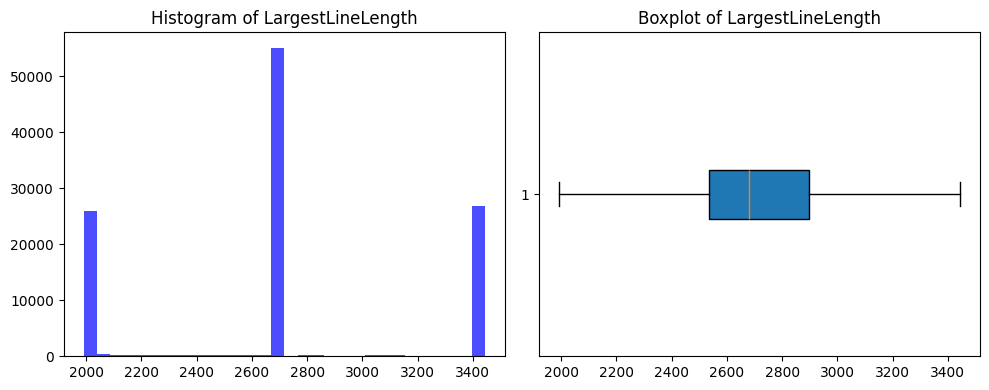

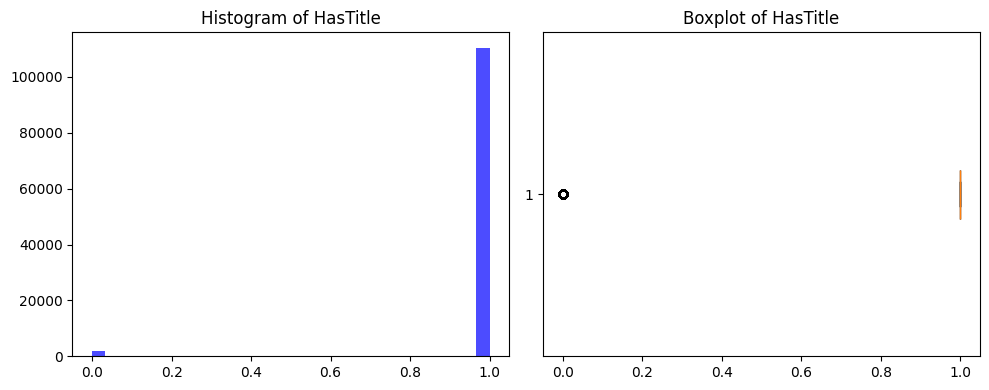

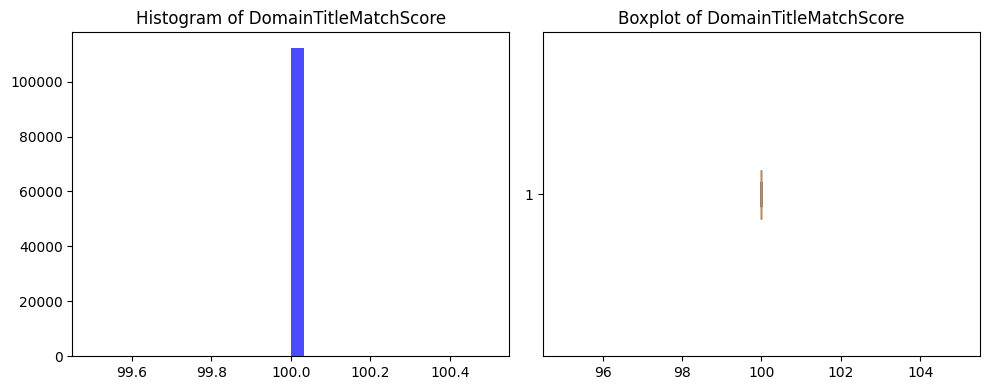

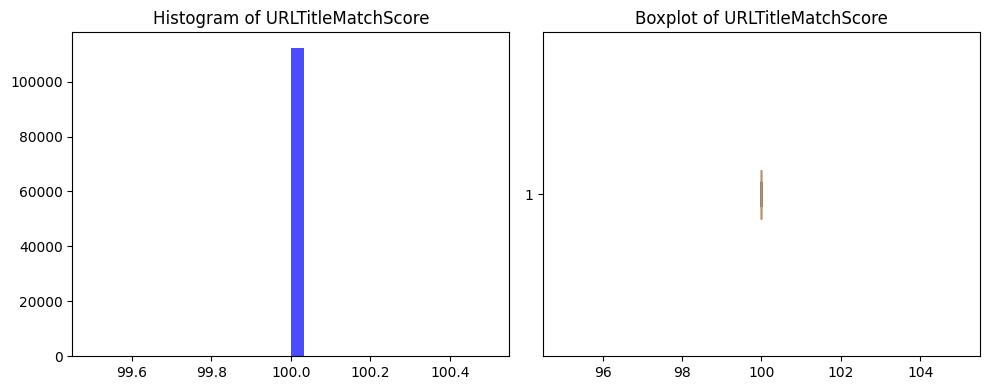

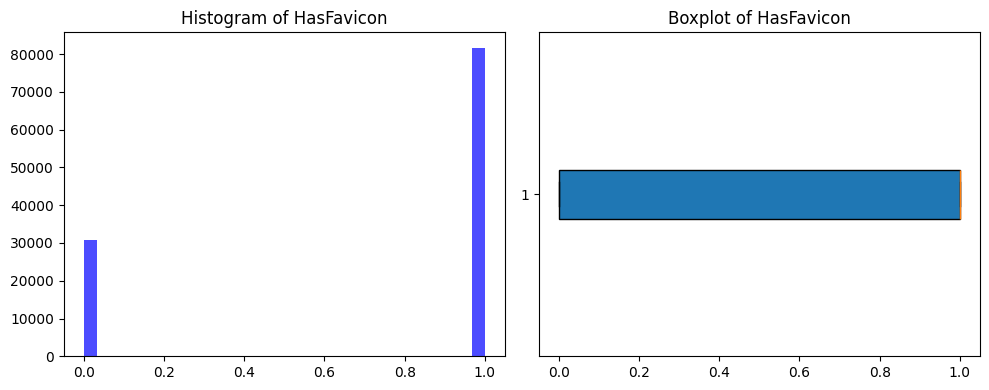

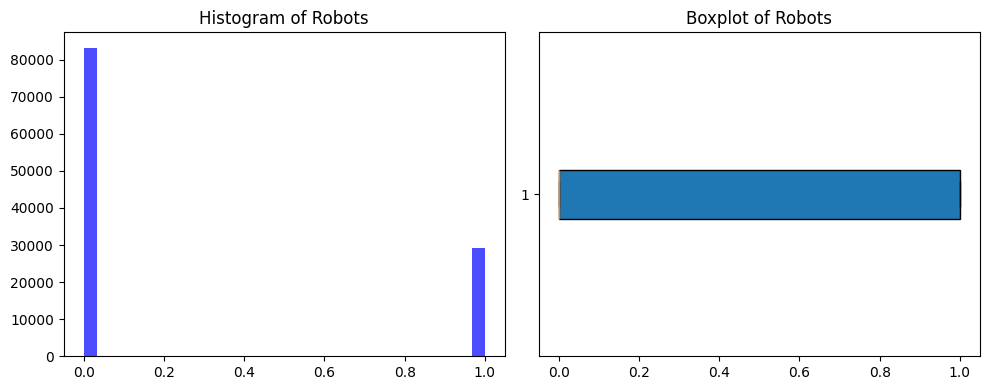

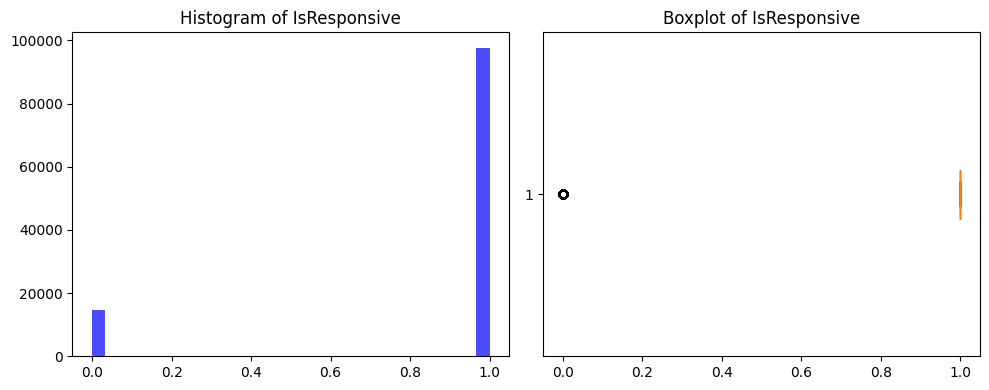

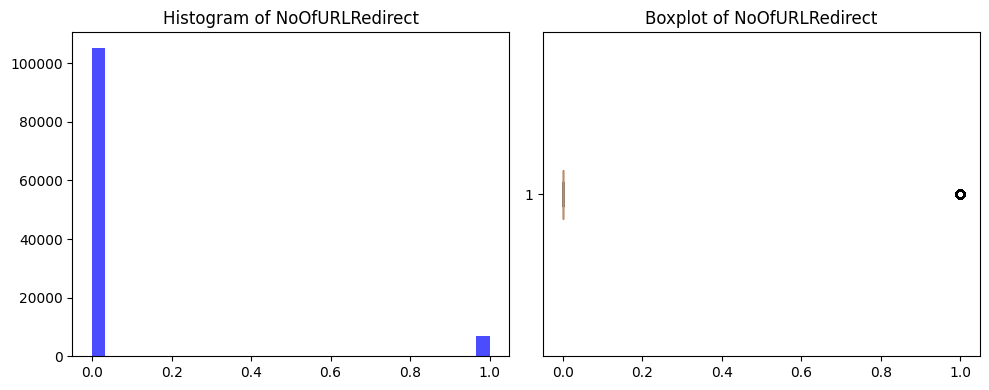

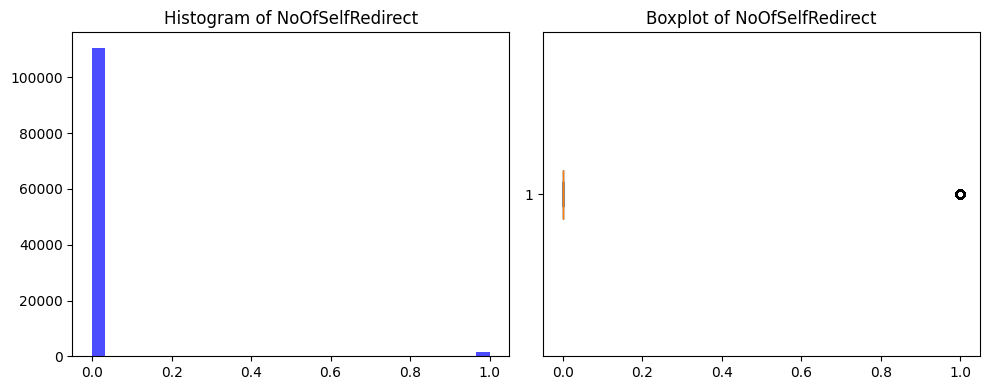

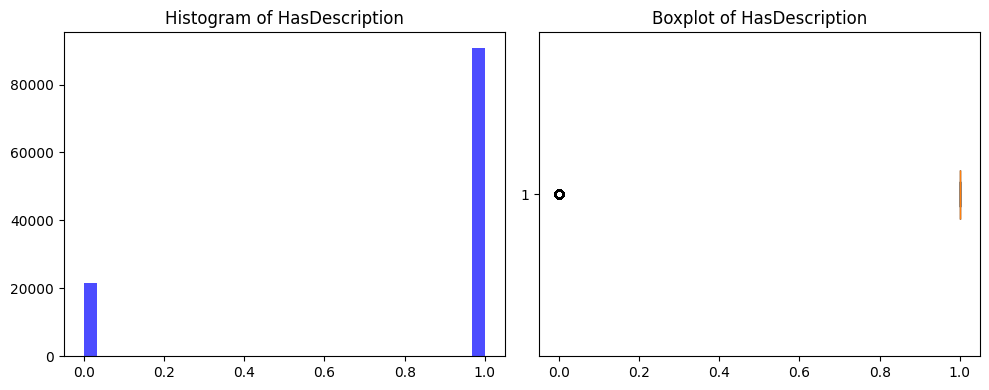

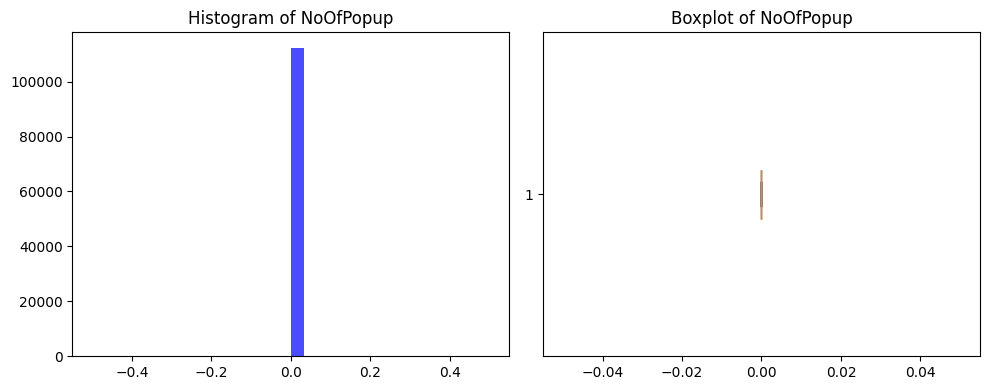

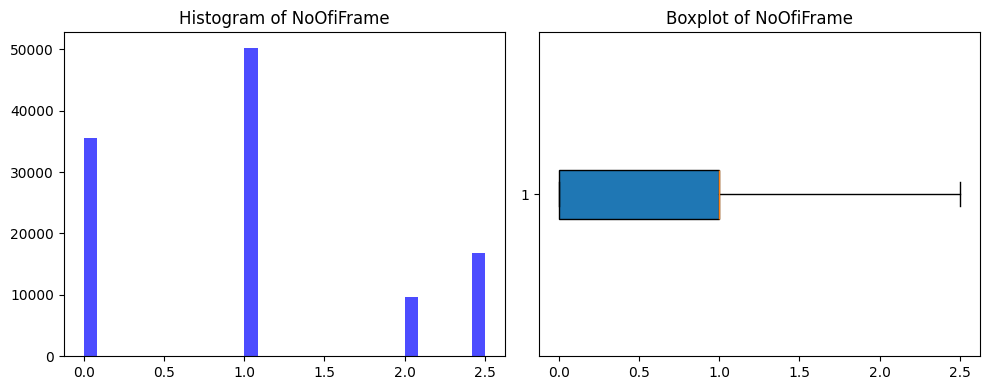

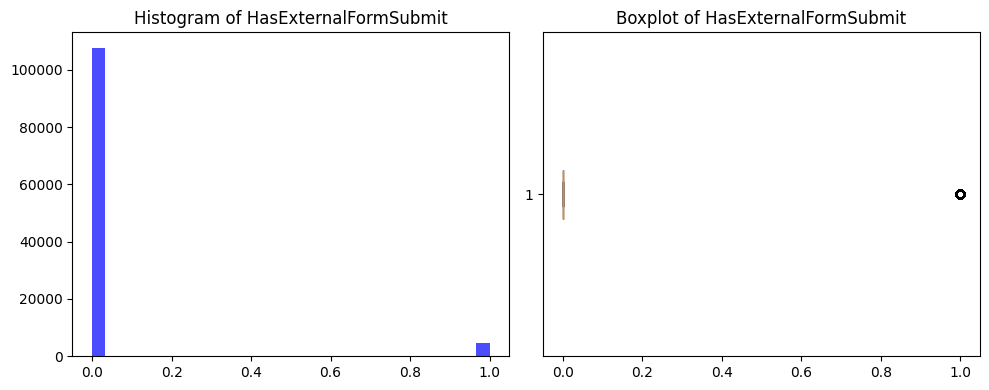

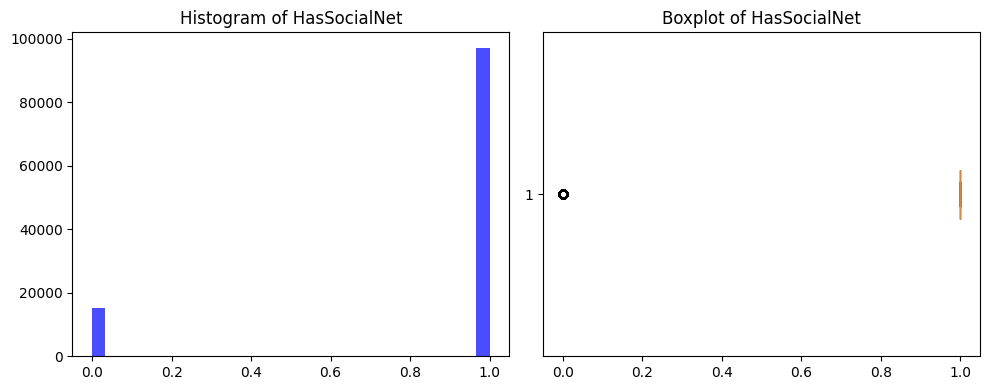

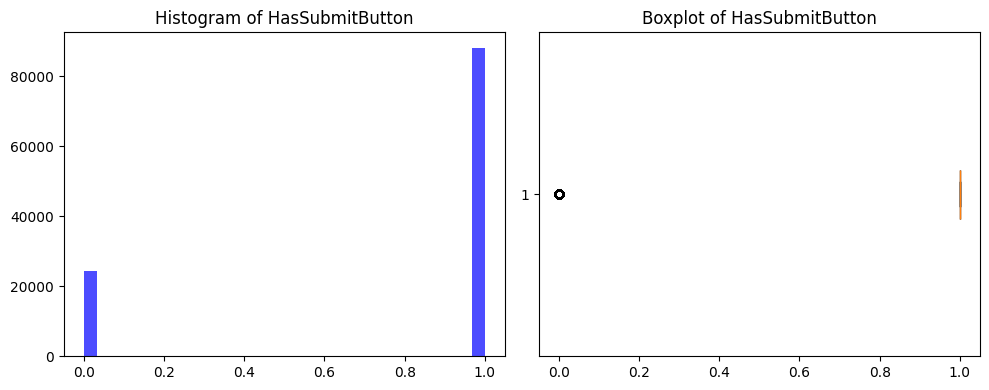

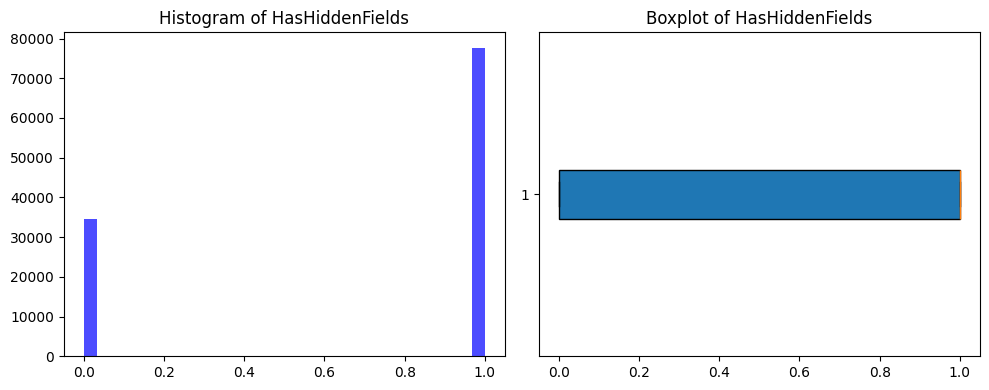

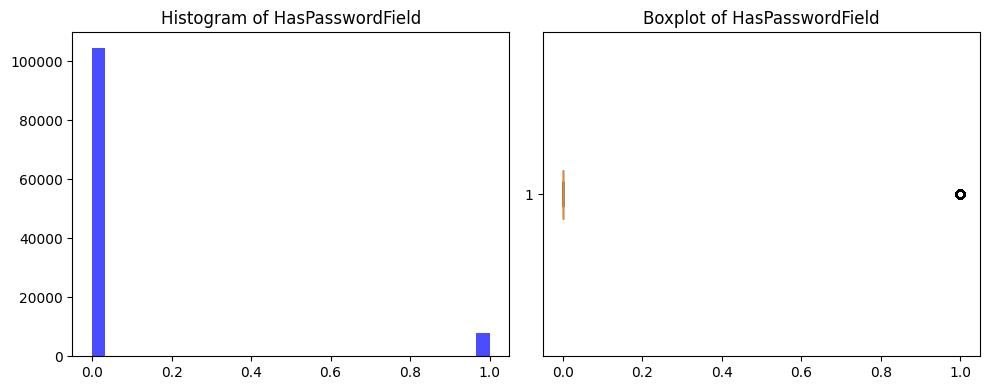

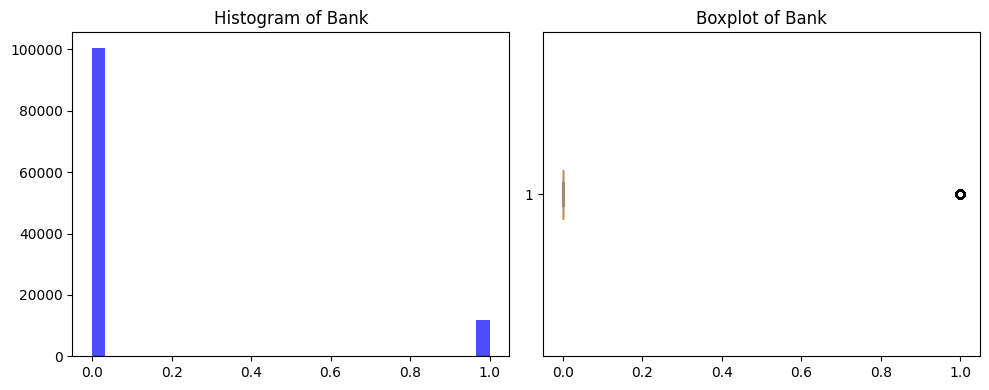

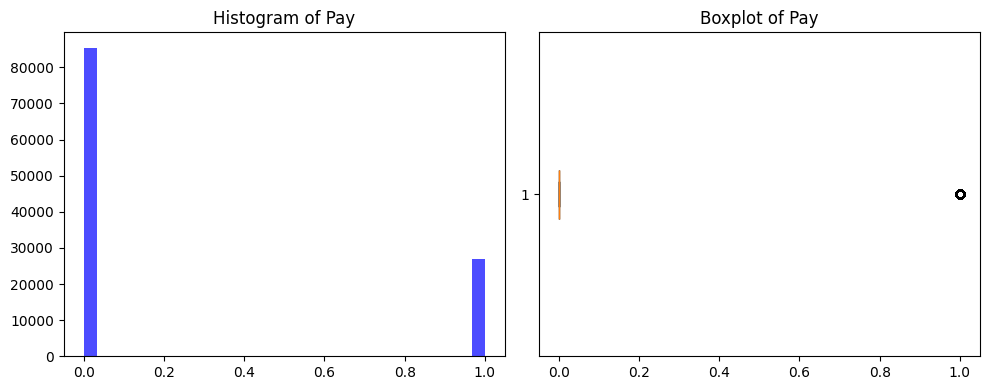

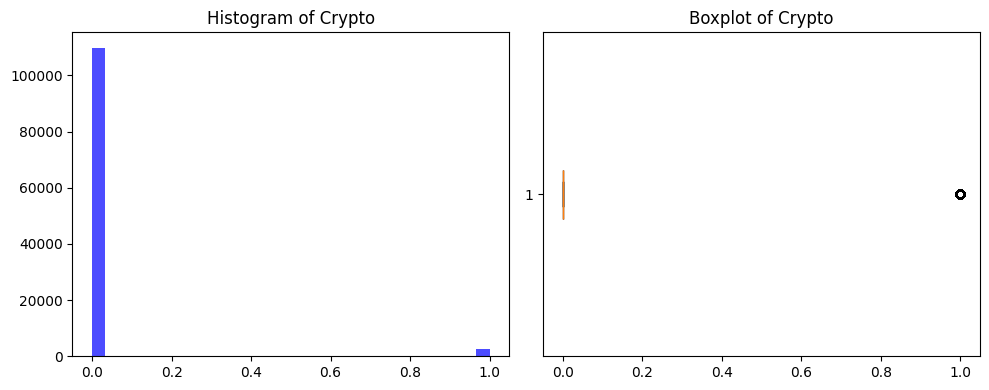

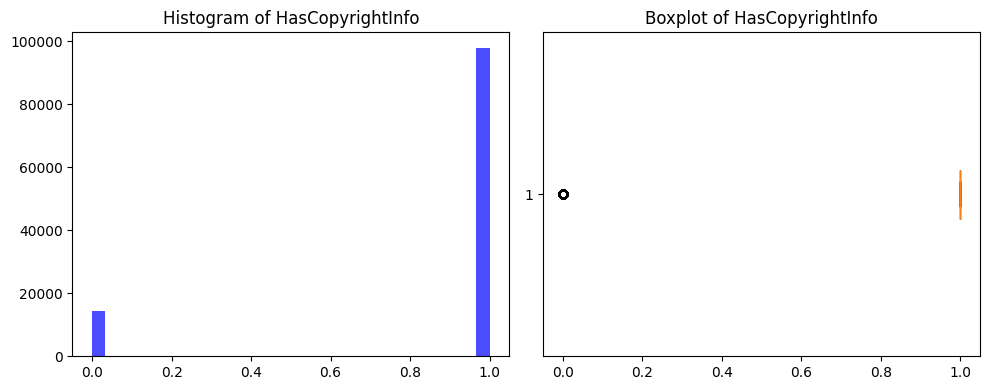

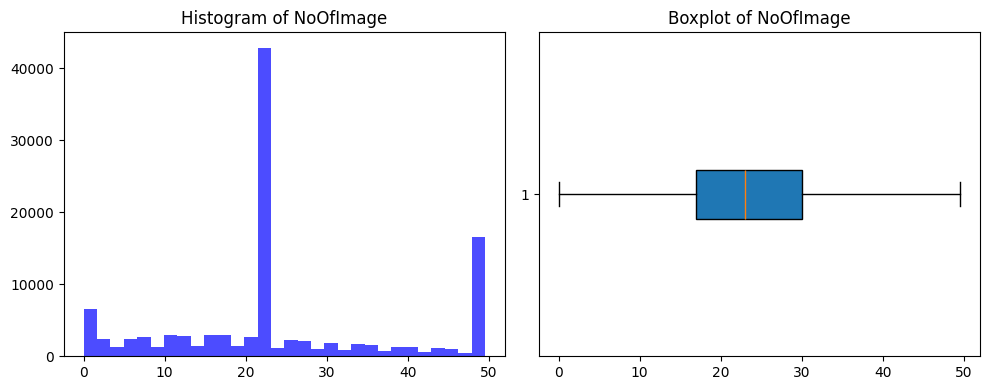

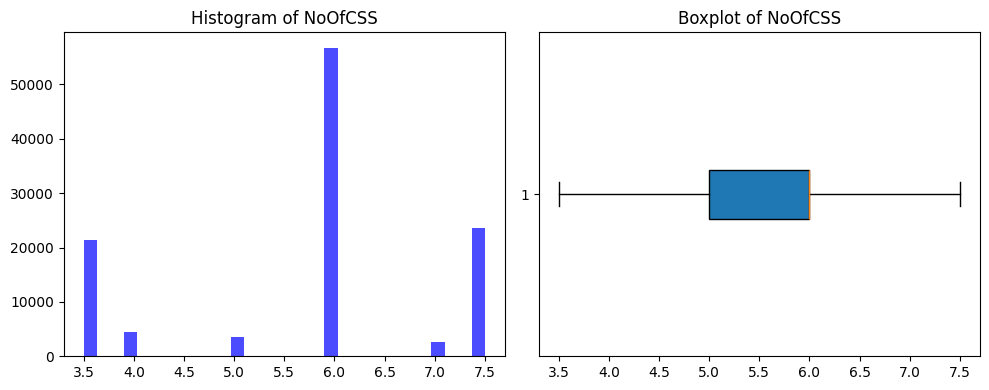

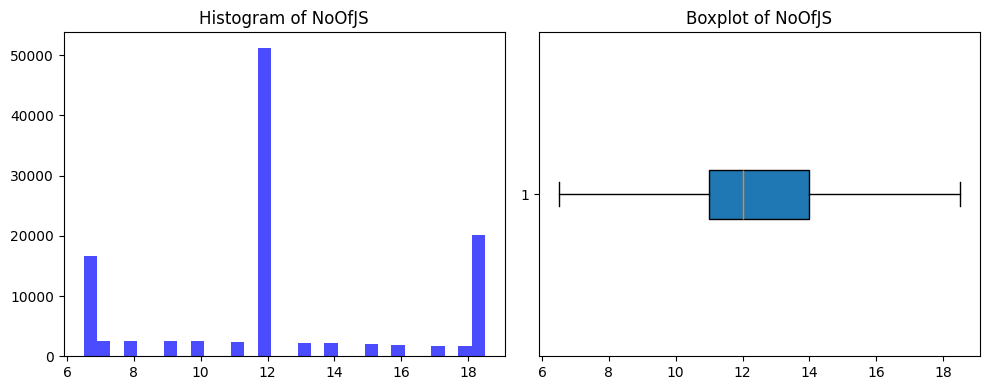

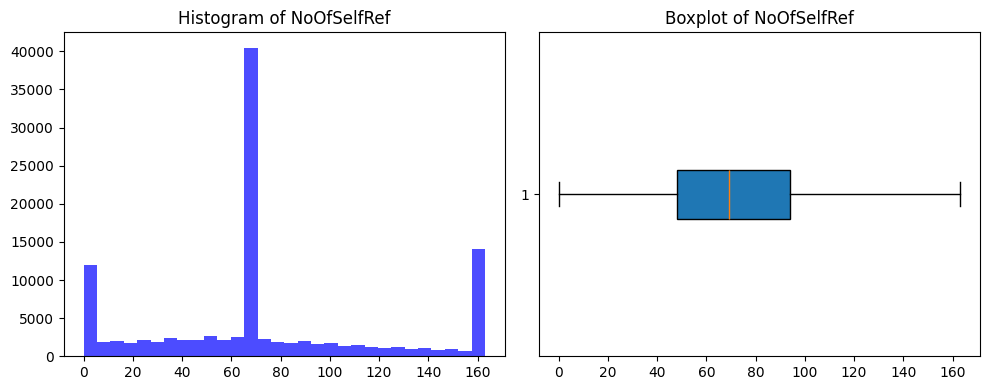

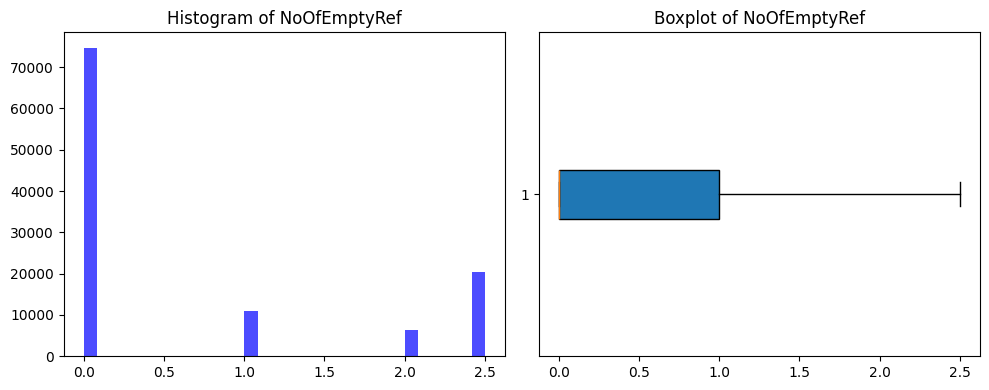

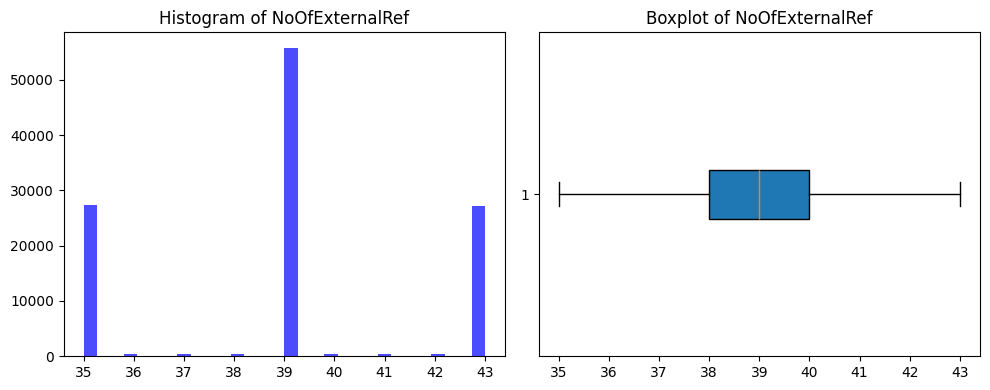

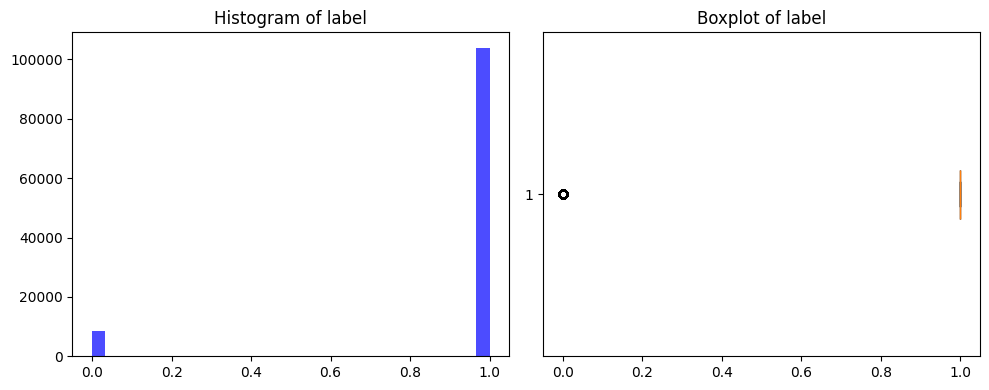

                            IQR Lower Bound  IQR Upper Bound  \
id                           -118309.000000    353919.000000   
URLLength                         22.000000        30.000000   
DomainLength                      11.000000        27.000000   
IsDomainIP                         0.000000         0.000000   
CharContinuationRate               1.000000         1.000000   
TLDLegitimateProb                 -0.584454         1.187324   
URLCharProb                        0.053637         0.066845   
TLDLength                          3.000000         3.000000   
NoOfSubDomain                      1.000000         1.000000   
HasObfuscation                     0.000000         0.000000   
NoOfObfuscatedChar                 0.000000         0.000000   
ObfuscationRatio                   0.000000         0.000000   
NoOfLettersInURL                  10.500000        14.500000   
LetterRatioInURL                   0.450000         0.530000   
NoOfDegitsInURL                    0.000

In [788]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore


numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns


outlier_analysis = {}


for col in numerical_columns:
    
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    z_scores = zscore(train_set[col].dropna())
    z_outliers = np.abs(z_scores) > 3  

    
    outlier_analysis[col] = {
        "IQR Lower Bound": lower_bound,
        "IQR Upper Bound": upper_bound,
        "Z-Score Outliers Count": z_outliers.sum(),
        "IQR Outliers Count": ((train_set[col] < lower_bound) | (train_set[col] > upper_bound)).sum(),
        "Skewness": train_set[col].skew()
    }

    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(train_set[col].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(train_set[col].dropna(), vert=False, patch_artist=True)
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


outlier_df = pd.DataFrame(outlier_analysis).T
print(outlier_df)


# Feature Engineering


In [789]:
# Pilih hanya kolom numerik
numerical_train_set = train_set.select_dtypes(include=['float64', 'int64'])

# Korelasi dengan target
correlation_with_target = numerical_train_set.corr()['label'].abs().sort_values(ascending=False)
print("Fitur dengan korelasi terhadap target:\n", correlation_with_target)


Fitur dengan korelasi terhadap target:
 label                         1.000000
IsHTTPS                       0.560261
HasTitle                      0.438480
NoOfImage                     0.320965
HasSocialNet                  0.316960
HasCopyrightInfo              0.304432
NoOfSelfRef                   0.301238
IsResponsive                  0.295489
HasDescription                0.274404
NoOfJS                        0.254368
NoOfCSS                       0.218161
HasSubmitButton               0.204365
LineOfCode                    0.203178
NoOfExternalRef               0.202680
NoOfiFrame                    0.197291
HasHiddenFields               0.195760
NoOfEmptyRef                  0.177775
HasFavicon                    0.172389
URLCharProb                   0.171202
SpacialCharRatioInURL         0.162046
Robots                        0.140861
LargestLineLength             0.140148
Pay                           0.132531
URLLength                     0.116684
NoOfLettersInURL        

In [790]:
# Periksa jumlah nilai unik di setiap kolom
print(train_set.nunique())

# Identifikasi kolom dengan nilai konstan
constant_columns = train_set.nunique()[train_set.nunique() <= 1].index
print("Kolom dengan nilai konstan:", constant_columns)

# Hapus kolom dengan nilai konstan
train_set = train_set.drop(columns=constant_columns)
val_set = val_set.drop(columns=constant_columns)


id                            112323
URLLength                          9
DomainLength                      17
IsDomainIP                         2
CharContinuationRate               1
TLDLegitimateProb                394
URLCharProb                    47658
TLDLength                          1
NoOfSubDomain                      1
HasObfuscation                     2
NoOfObfuscatedChar                 1
ObfuscationRatio                   1
NoOfLettersInURL                   6
LetterRatioInURL                  62
NoOfDegitsInURL                    1
DegitRatioInURL                    1
NoOfEqualsInURL                    1
NoOfQMarkInURL                     1
NoOfAmpersandInURL                 1
NoOfOtherSpecialCharsInURL         1
SpacialCharRatioInURL              6
IsHTTPS                            2
LineOfCode                       169
LargestLineLength               1375
HasTitle                           2
DomainTitleMatchScore              1
URLTitleMatchScore                 1
H

In [791]:
numerical_train_set = train_set.select_dtypes(include=['float64', 'int64'])

correlation_with_target = numerical_train_set.corrwith(train_set['label']).abs()

nan_correlation_features = correlation_with_target[correlation_with_target.isna()].index

low_correlation_features = correlation_with_target[correlation_with_target < 0.1].index

features_to_drop = nan_correlation_features.union(low_correlation_features)

train_set = train_set.drop(columns=features_to_drop, errors='ignore')
val_set = val_set.drop(columns=features_to_drop, errors='ignore')

In [792]:
# Fitur dengan korelasi tinggi
high_corr_features = ['IsHTTPS', 'HasTitle', 'NoOfImage', 'HasSocialNet', 'HasCopyrightInfo']

# Buat interaksi antar fitur dengan perkalian
for i in range(len(high_corr_features)):
    for j in range(i + 1, len(high_corr_features)):
        feature_1 = high_corr_features[i]
        feature_2 = high_corr_features[j]
        new_feature_name = f"{feature_1}_x_{feature_2}"
        train_set[new_feature_name] = train_set[feature_1] * train_set[feature_2]
        val_set[new_feature_name] = val_set[feature_1] * val_set[feature_2]

print("Fitur interaksi baru ditambahkan.")


Fitur interaksi baru ditambahkan.


In [793]:
# Identifikasi kolom numerik
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns

# Pilih fitur kontinu berdasarkan jumlah nilai unik (lebih dari 5)
continuous_features = [col for col in numerical_columns if train_set[col].nunique() > 5]

# Hapus kolom biner (hanya memiliki nilai 0 dan 1)
binary_features = [col for col in numerical_columns if set(train_set[col].unique()) <= {0, 1}]
continuous_features = [col for col in continuous_features if col not in binary_features]

print("Fitur dengan distribusi kontinu:", continuous_features)


Fitur dengan distribusi kontinu: ['URLLength', 'URLCharProb', 'NoOfLettersInURL', 'LetterRatioInURL', 'SpacialCharRatioInURL', 'LineOfCode', 'LargestLineLength', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfExternalRef', 'IsHTTPS_x_NoOfImage', 'HasTitle_x_NoOfImage', 'NoOfImage_x_HasSocialNet', 'NoOfImage_x_HasCopyrightInfo']


In [794]:
# Mapping kategori ordinal ke angka
labels_mapping = {'very_low': 1, 'low': 2, 'medium': 3, 'high': 4, 'very_high': 5}

# Equal-width binning untuk fitur kontinu
for col in continuous_features:
    train_set[f'{col}_binned'] = pd.cut(train_set[col], bins=5, labels=[1, 2, 3, 4, 5])
    val_set[f'{col}_binned'] = pd.cut(val_set[col], bins=5, labels=[1, 2, 3, 4, 5])

print("Equal-width binning selesai untuk semua fitur kontinu.")

Equal-width binning selesai untuk semua fitur kontinu.


# Data Preprocessing

## Feature Scalling

In [795]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.q1 = None
        self.q3 = None
        self.iqr = None

    def fit(self, X, y=None):
        X = np.array(X)
        self.q1 = np.percentile(X, 25, axis=0)
        self.q3 = np.percentile(X, 75, axis=0)
        self.iqr = self.q3 - self.q1
        return self

    def transform(self, X):
        X = np.array(X)
        return (X - self.q1) / np.where(self.iqr == 0, 1, self.iqr)

## Handling Imbalanced Dataset

In [796]:
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

class SMOTEWrapper:
    def __init__(self, random_state=42):
        self.smote = SMOTE(random_state=random_state)

    def fit_resample(self, X, y):
        return self.smote.fit_resample(X, y)

# Pipelining

In [797]:
from sklearn.pipeline import Pipeline

# Pipeline untuk Feature Scaling
preprocessing_pipeline = Pipeline([
    ("scaler", FeatureScaler())  # Robust Scaling
])


In [798]:
# Pisahkan fitur dan target dari train_set dan val_set
X_train = train_set.drop(columns=['label'])
y_train = train_set['label']

X_val = val_set.drop(columns=['label'])
y_val = val_set['label']

# Preprocessing pada training set (Feature Scaling)
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# Terapkan SMOTE setelah preprocessing
smote = SMOTEWrapper(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Preprocessing pada validation set (tanpa SMOTE)
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

print("Preprocessing selesai!")
print("Shape X_train setelah SMOTE dan Scaling:", X_train_resampled.shape)
print("Shape X_val setelah Scaling:", X_val_preprocessed.shape)


Preprocessing selesai!
Shape X_train setelah SMOTE dan Scaling: (207842, 51)
Shape X_val setelah Scaling: (28081, 51)


/Users/attarlisan/Documents/Tubes2_AI/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [799]:
import numpy as np
from collections import Counter

class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

    def _predict_one(self, x):
        # Hitung jarak Euclidean
        distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        # Ambil k tetangga terdekat
        k_indices = np.argsort(distances)[:self.k]
        k_labels = self.y_train[k_indices]
        # Voting mayoritas
        most_common = Counter(k_labels).most_common(1)
        return most_common[0][0]

# Latih model
knn_scratch = KNearestNeighbors(k=5)
knn_scratch.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_knn_scratch = knn_scratch.predict(X_val_preprocessed)


KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Latih model
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
knn_sklearn.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_knn_sklearn = knn_sklearn.predict(X_val_preprocessed)

# Evaluasi
print("KNN (Scikit-Learn) Accuracy:", accuracy_score(y_val, y_pred_knn_sklearn))
print("KNN (Scikit-Learn) Classification Report:\n", classification_report(y_val, y_pred_knn_sklearn))


In [ ]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {cls: np.mean(y == cls) for cls in self.classes}
        self.class_means = {cls: X[y == cls].mean(axis=0) for cls in self.classes}
        self.class_variances = {cls: X[y == cls].var(axis=0) for cls in self.classes}

    def predict(self, X):
        X = np.array(X)
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

    def _predict_one(self, x):
        posteriors = []
        for cls in self.classes:
            prior = np.log(self.class_priors[cls])
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[cls]))
            likelihood -= 0.5 * np.sum(((x - self.class_means[cls]) ** 2) / (self.class_variances[cls] + 1e-9))
            posteriors.append(prior + likelihood)
        return self.classes[np.argmax(posteriors)]

# Latih model
nb_scratch = NaiveBayes()
nb_scratch.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_nb_scratch = nb_scratch.predict(X_val_preprocessed)


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Latih model
nb_sklearn = GaussianNB()
nb_sklearn.fit(X_train_resampled, y_train_resampled)

# Prediksi pada validation set
y_pred_nb_sklearn = nb_sklearn.predict(X_val_preprocessed)

# Evaluasi
print("Naive Bayes (Scikit-Learn) Accuracy:", accuracy_score(y_val, y_pred_nb_sklearn))
print("Naive Bayes (Scikit-Learn) Classification Report:\n", classification_report(y_val, y_pred_nb_sklearn))


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluasi KNN Scratch
print("KNN (Scratch) Accuracy:", accuracy_score(y_val, y_pred_knn_scratch))
print("KNN (Scratch) Classification Report:\n", classification_report(y_val, y_pred_knn_scratch))

# Evaluasi Naive Bayes Scratch
print("Naive Bayes (Scratch) Accuracy:", accuracy_score(y_val, y_pred_nb_scratch))
print("Naive Bayes (Scratch) Classification Report:\n", classification_report(y_val, y_pred_nb_scratch))
